# Importing the Libraries


In [99]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import SimpleImputer
from sklearn.feature_extraction.text import CountVectorizer
from scipy import stats

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# Datasets


In [100]:
# Importing the Philadelphia buildings dataset

df1 = pd.read_csv('phl_buildings.csv')
df1.head()

,OBJECTID,BIN,FCODE,ADDRESS,BUILDING_NAME,BASE_ELEVATION,APPROX_HGT,MAX_HGT,PARCEL_ID_NUM,PARCEL_ID_SOURCE,Shape__Area,Shape__Length
0,51065281,1000001,1810,1501 N 18TH ST,NaN,104.2,20.0,28.0,319860,PWD,97.761719,40.383631
1,51065282,1000002,1810,1501 N 18TH ST,NaN,103.3,20.0,29.0,319860,PWD,99.632812,40.691884
2,51065283,1000003,1810,1501 N 18TH ST,NaN,103.9,20.0,28.0,319860,PWD,96.292969,40.145485
3,51065284,1000004,1810,1501 N 18TH ST,NaN,103.6,20.0,28.0,319860,PWD,98.699219,40.543015
4,51065285,1000005,1810,1501 N 18TH ST,NaN,108.0,20.0,30.0,319860,PWD,101.902344,42.790290


In [101]:
print(f"No. of rows in df1:", len(df1))
print(f"No. columns in df1:", len(df1.columns))

No. of rows in df1: 543278
No. columns in df1: 12


In [102]:
# Importing the Philadelphia Properties dataset
df2 = pd.read_csv("phl_properties.csv", low_memory = False)

print(f"No. of rows in df2:", len(df2))
print(f"No. columns in df2:", len(df2.columns))

No. of rows in df2: 581456
No. columns in df2: 75


<b> Since we are interested in in property prie prediction. That's why we are nly going to use the Philadelphia Properties dataset. </b>


In [103]:
df = df2.copy()

In [104]:
# Removing the columns which do not contribute to the property price

df.drop(columns=['assessment_date','beginning_point','book_and_page','census_tract','cross_reference','date_exterior_condition',
                 'exempt_building','exempt_land','geographic_ward','homestead_exemption','house_extension','house_number',
                 'mailing_zip','market_value_date','off_street_open','separate_utilities','sewer','site_type','state_code',
                 'street_code','street_direction','street_name','suffix','taxable_building','taxable_land','utility',
                 'year_built_estimate','objectid','mailing_address_1','mailing_address_2','mailing_care_of','mailing_city_state',
                 ], inplace=True)

In [105]:
df.head()

,basements,building_code,building_code_description,category_code,category_code_description,central_air,depth,exterior_condition,fireplaces,frontage,...,topography,total_area,total_livable_area,type_heater,unfinished,unit,view_type,year_built,zip_code,zoning
0,D,P50,ROW W/GAR 3 STY MASONRY,1,Single Family,N,49.0,5.0,0.0,15.90,...,F,779.0,1650.0,H,NaN,NaN,I,1920,191475425,RSA5
1,D,O50,ROW 3 STY MASONRY,1,Single Family,Y,49.0,2.0,0.0,15.90,...,F,779.1,1203.0,H,NaN,NaN,I,1920,191475425,RSA5
2,D,O50,ROW 3 STY MASONRY,1,Single Family,N,49.0,4.0,0.0,14.80,...,F,725.2,1482.0,H,NaN,NaN,I,1920,191475425,RSA5
3,D,O50,ROW 3 STY MASONRY,1,Single Family,Y,100.0,4.0,0.0,14.33,...,F,1433.0,2049.0,A,NaN,NaN,I,1920,191475425,RSA5
4,C,O50,ROW 3 STY MASONRY,1,Single Family,N,100.0,4.0,0.0,15.00,...,F,1500.0,1155.0,H,NaN,NaN,I,1920,191475425,RSA5


In [106]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 581456 entries, 0 to 581455
Data columns (total 43 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   basements                  325571 non-null  object 
 1   building_code              581456 non-null  object 
 2   building_code_description  581456 non-null  object 
 3   category_code              581456 non-null  int64  
 4   category_code_description  581456 non-null  object 
 5   central_air                285860 non-null  object 
 6   depth                      581454 non-null  float64
 7   exterior_condition         556191 non-null  float64
 8   fireplaces                 581435 non-null  float64
 9   frontage                   581454 non-null  float64
 10  fuel                       10900 non-null   object 
 11  garage_spaces              581435 non-null  float64
 12  garage_type                530522 non-null  object 
 13  general_construction       51

To ease the exploratory data analysis process, we grouped the columns based on its types and its connections with other columns.

1. Property Location:
    * Location, Street Designation
2. Classification of Property:
    * Building code, Building code description, Category code, Category code description
    * Unit
    * Zoning
    * Unfinished
    * Zip code
3. Property Specifications:
    * Basements, Garage type, Garage spaces
    * Central air, Fireplaces, Other building, Unfinished, Topography, View type
    * Depth, Frontage, Total area, Total livable area
    * Exterior condition, Interior condition, Quality grade, General construction
    * Fuel, Type heater
    * Number of bathrooms, Number of bedrooms, Number of rooms, Number stories, Year built 
    * Market value, Sale price, Sale date
4. Others:
    * Parcel number, Parcel shape
    * Recording date, registry number


# Cleaning and Initial EDA of Features

<strong> Category Code, Building Code and Zoning </strong>

In [107]:
df[['category_code','category_code_description']].dtypes

category_code                 int64
category_code_description    object
dtype: object

In [108]:
df['category_code'].value_counts()

1    461573
6     44612
2     42462
3     14396
4     14059
5      4354
Name: category_code, dtype: int64

In [109]:
df['category_code_description'].value_counts()

Single Family    461573
Vacant Land       44612
Multi Family      42462
Mixed Use         14396
Commercial        14059
Industrial         4354
Name: category_code_description, dtype: int64

<b> Building Code </b>

In [110]:
df[['building_code','building_code_description']].dtypes

building_code                object
building_code_description    object
dtype: object

In [111]:
df[['building_code','building_code_description']].nunique()

building_code                802
building_code_description    798
dtype: int64

<b> Zoning </b>


In [112]:
df['zoning'].dtypes

dtype('O')

In [113]:
df['zoning'].nunique()

43

In [114]:
df['zoning'] = df['zoning'].apply(lambda x: str(x).strip())
df['zoning'].unique()

array(['RSA5', 'ICMX', 'RM1', 'CMX1', 'I2', 'CMX2', 'RMX2', 'CMX25',
       'CA1', 'nan', 'CMX3', 'SPPOA', 'RM2', 'RSA3', 'CMX2.', 'CMX4',
       'RSA1', 'RSD1', 'IRMX', 'RMX3', 'CMX5', 'RM4', 'I1', 'RS3', 'RSA2',
       'RTA1', 'RSD3', 'RMX1', 'RM3', 'RSA', 'SPINS', 'RSD2', 'CA2', 'I3',
       'SPAIR', 'RSA4', '12', 'IP', 'SPSTA', 'SC', 'SPENT', '2002',
       'SPPOP', 'SP'], dtype=object)

In [115]:
df['zoning'].value_counts()

RSA5     288769
RM1      105876
RSA3      62750
CMX2      20772
RSD3      13180
RSA2      12602
RSA4      12188
CMX3       8053
RTA1       5766
RM2        5547
CMX1       5445
CMX5       4915
CMX25      4335
I2         4270
CMX4       4194
RM4        3814
RSD1       3270
ICMX       2993
RMX3       2276
RSA1       1294
RM3        1292
RMX1       1275
RSD2       1274
SPPOA       868
CA1         844
I1          725
IRMX        708
CA2         628
I3          433
SPINS       366
RMX2        271
CMX2.       211
nan         133
12           45
SPAIR        23
IP           23
SPSTA        16
RSA           3
SPENT         3
SPPOP         2
2002          1
RS3           1
SC            1
SP            1
Name: zoning, dtype: int64

<b> Dropping Anomalies </b>


In [116]:
index = df[df['zoning']=='2002'].index
df.drop(index=index, axis=0, inplace=True)

In [117]:
index = df[df['zoning']=='SP'].index
df.drop(index=index, axis=0, inplace=True)

In [118]:
index = df[df['zoning']=='RS3'].index
df.drop(index=index, axis=0, inplace=True)

In [119]:
index = df[df['zoning']=='SC'].index
df.drop(index=index, axis=0, inplace=True)

In [120]:
index = df[df['zoning']=='RSA'].index
df.drop(index=index, axis=0, inplace=True)

<b> Fixing Typos </b>

In [121]:
df['zoning'] = df['zoning'].apply(lambda x: 'I2' if x=='12' else x)

In [122]:
df['zoning'] = df['zoning'].apply(lambda x: 'CMX2' if x=='CMX2' else x)


In [123]:
df['zoning'] = df['zoning'].apply(lambda x: np.nan if x=='nan' else x)


In [124]:
df['zoning'].isna().sum()

133

<b> Dropping NAs </b>

In [125]:
index = df[df['zoning'].isna()].index
df.drop(index=index, axis=0, inplace=True)

In [126]:
df['zoning'].isna().sum()

0

In [127]:
df['new_zoning']=df['zoning'].apply(lambda x: 'Residential Single Family' if (x=='RSD1') | (x=='RSD2') | (x=='RSD3') 
                   | (x=='RSA1') | (x=='RSA2') | (x=='RSA3') | (x=='RSA4') | (x=='RSA5') else 
                   'Residential Two Family' if (x=='RTA1') else
                   'Residential Multi Family' if (x=='RM1') | (x=='RM2') | (x=='RM3') | (x=='RM4') else
                   'Mixed Used' if (x=='RMX1') | (x=='RMX2') | (x=='RMX3') | (x=='CMX1') | (x=='CMX2') 
                   | (x=='CMX25') | (x=='CMX3') | (x=='CMX4') | (x=='CMX5') | (x=='ICMX') | (x=='IRMX')else
                   'Commercial' if (x=='CA1') | (x=='CA2') else
                   'Industrial' if (x=='I1') | (x=='I2') | (x=='I3') | (x=='IP') else 
                   'Special Purpose Airport' if (x=='SPAIR') else 
                   'Special Purpose Institution' if (x=='SPINS') else 
                   'Special Purpose Entertainment' if (x=='SPENT') else 
                   'Special Purpose Stadium' if (x=='SPSTA') else 
                   'Special Purpose Open Space-Active' if (x=='SPPOA') else 
                   'Special Purpose Open Space-Passive' if (x=='SPPOP') else '0')

In [128]:
df['new_zoning'].value_counts()

Residential Single Family             395327
Residential Multi Family              116529
Mixed Used                             55237
Residential Two Family                  5766
Industrial                              5496
Commercial                              1472
Special Purpose Open Space-Active        868
Special Purpose Institution              366
0                                        211
Special Purpose Airport                   23
Special Purpose Stadium                   16
Special Purpose Entertainment              3
Special Purpose Open Space-Passive         2
Name: new_zoning, dtype: int64

<strong> Crosschecking Category and Building Code </strong>

In [129]:
df['new_zoning']

0         Residential Single Family
1         Residential Single Family
2         Residential Single Family
3         Residential Single Family
4         Residential Single Family
                    ...            
581451                   Mixed Used
581452                   Mixed Used
581453                   Mixed Used
581454                   Mixed Used
581455                   Mixed Used
Name: new_zoning, Length: 581316, dtype: object

In [130]:
pd.set_option('display.max_rows',802)
df.groupby('category_code_description')['building_code_description'].value_counts()

category_code_description  building_code_description 
Commercial                 STORE 1 STY MASONRY             1549
                           AUTO REPAIR SHOP MASONRY        1109
                           HSE WORSHIP ALL 2 STY MAS        740
                           COM CONDO 1 STY MASONRY          721
                           HSE WORSHIP ALL 1 STY MAS        552
                           STORE 2 STY MASONRY              462
                           STR/OFF 2 STY MASONRY            455
                           STR/OFF 1 STY MASONRY            434
                           MISC DAY CARE MASONRY            353
                           HSE WORSHIP ALL 3 STY MAS        327
                           OFF BLD N/COM W/PKG MASON        294
                           OFF BLD N/PKG N/COM MASON        273
                           SCHOOL 3 STY MASONRY             271
                           REST'RNT W/BAR MASONRY           261
                           STORE 3 STY MASONRY    

In [131]:
def checking(c):
    c = c.str.extractall('([a-zA-Z]+)')
    c.columns=['check']
    b = c.reset_index(drop=True)
    c = b['check'].value_counts()
    
    checking = {'checking':c.index, 'freq':c.values}
    checking = pd.DataFrame(checking)
    checking.index = checking['checking']
    checking.drop('checking',axis=1,inplace=True)
    checking.sort_values('freq',ascending=False,inplace=True)
    return checking

In [132]:
check_1=checking(df[df['category_code']==1]['building_code_description'])
check_2=checking(df[df['category_code']==2]['building_code_description'])
check_3=checking(df[df['category_code']==3]['building_code_description'])
check_4=checking(df[df['category_code']==4]['building_code_description'])
check_5=checking(df[df['category_code']==5]['building_code_description'])
check_6=checking(df[df['category_code']==6]['building_code_description'])

In [133]:
check_1.rename(columns={'freq':'Single Family'},inplace=True)
check_2.rename(columns={'freq':'Multi Family'},inplace=True)
check_3.rename(columns={'freq':'Mixed Use'},inplace=True)
check_4.rename(columns={'freq':'Commercial'},inplace=True)
check_5.rename(columns={'freq':'Industrial'},inplace=True)
check_6.rename(columns={'freq':'Vacant Land'},inplace=True)

In [134]:
check_count = pd.concat([check_1,check_2,check_3,check_4,check_5,check_6],axis=1)
check_count.fillna(0,inplace=True)

In [135]:
check_count

,Single Family,Multi Family,Mixed Use,Commercial,Industrial,Vacant Land
checking,,,,,,
STY,459237.0,37284.0,14396.0,7336.0,4.0,0.0
MASONRY,406197.0,5151.0,6867.0,9618.0,3966.0,0.0
ROW,332555.0,16173.0,7051.0,0.0,0.0,0.0
GAR,177091.0,0.0,0.0,369.0,0.0,0.0
B,145700.0,0.0,797.0,0.0,0.0,0.0
W,66418.0,0.0,6303.0,814.0,0.0,0.0
DET,56920.0,1008.0,218.0,0.0,0.0,0.0
D,51978.0,5318.0,440.0,0.0,0.0,0.0
S,38755.0,5318.0,440.0,5.0,0.0,0.0


By skimming two tables above, it seems that the category code was classified using building code description. But, since the data is a lot to check with, we will answer the question using a simple modeling.

In [136]:
text = df['building_code_description']
label = df['category_code_description']


In [137]:
text_train, text_test, y_train, y_test = train_test_split(text, label, stratify=label, random_state=2020)

In [138]:
vect = CountVectorizer().fit(text_train)

In [139]:
x_train = vect.transform(text_train)
x_test = vect.transform(text_test)

In [140]:
feature = vect.get_feature_names_out()

In [141]:
model = LogisticRegression(n_jobs=-1)
model.fit(x_train, y_train)
y_pred = model.predict(x_test)

In [142]:
print(classification_report(y_test, y_pred))

               precision    recall  f1-score   support

   Commercial       0.98      1.00      0.99      3513
   Industrial       1.00      1.00      1.00      1088
    Mixed Use       1.00      0.98      0.99      3599
 Multi Family       1.00      1.00      1.00     10601
Single Family       1.00      1.00      1.00    115388
  Vacant Land       1.00      1.00      1.00     11140

     accuracy                           1.00    145329
    macro avg       1.00      1.00      1.00    145329
 weighted avg       1.00      1.00      1.00    145329



This model proves that building code description can specifically predict which category code the data belongs to. It's very specific that it proves that there are no misclassification of category code in the dataset.

This also confirms that category code is representing the type of the property, not the building. For example, logically, condominium (CONDO) should be classified into multi family if category code represents the building.

In [143]:
df[df['building_code_description'].str.contains('CONDO')].value_counts('category_code_description')

category_code_description
Single Family    34656
Commercial         932
Industrial         101
dtype: int64

Changing the Category Code Description to following.
* Resident
* Hotel and Apartments
* Store and Dwelling
*  Commercial
*  Industrial
*  Vacant Land

In [144]:
dupe = pd.read_csv('./Data/dupe.csv')
dupe.drop(columns=['Unnamed: 0'], inplace=True)
len(dupe)

3634

In [145]:
df_dupe = df[df['location'].isin(dupe['dupe'])]
len(df_dupe)

37692

In [146]:
len(df_dupe)/len(df)*100

6.483908923889932

We have 37692 (6.5% from total) data with duplicate 'location'.

# Crosschecking

In [147]:
df['unit'].dtypes

dtype('O')

In [148]:
df['unit'].nunique()

8761

In [149]:
len(df[df['unit'].notna()])

38717

In [150]:
len(df_dupe[df_dupe['unit'].notna()])/len(df[df['unit'].notna()])*100

96.19546969031691

Most of the data with filled 'unit' value were located in data with duplicate 'location' value (df_dupe).

In [151]:
check = df_dupe[['location','unit','sale_date']].sort_values(by=['location','unit'])
check[0:100]

,location,unit,sale_date
575439,1 ACADEMY CIR,00000P1,2009-08-03 00:00:00
570503,1 ACADEMY CIR,00000P2,2011-08-12 00:00:00
575440,1 ACADEMY CIR,00000P3,2016-04-22 00:00:00
575441,1 ACADEMY CIR,00000P4,2016-07-01 00:00:00
575442,1 ACADEMY CIR,00000P5,2007-01-25 00:00:00
575443,1 ACADEMY CIR,00000P6,2006-11-17 00:00:00
575444,1 ACADEMY CIR,00000P7,2009-09-29 00:00:00
575445,1 ACADEMY CIR,00000P8,2006-10-23 00:00:00
575446,1 ACADEMY CIR,00000P9,2006-10-25 00:00:00
573269,1 ACADEMY CIR,0000101,2019-06-17 00:00:00


In [152]:
location = []
for i in check['location'].unique():
    unit = []
    for j in check[check['location']==i]['unit']:
        if j not in unit:
            unit.append(j)
        elif j in unit:
            location.append(i)
location

['1100 S CHRIS COLUMBUS BLV',
 '1126-36 ARCH ST',
 '115 SOUTH ST',
 '1341 S CHRIS COLUMBUS BLV',
 '1401 S CHRIS COLUMBUS BLV',
 '1500 JOHN F KENNEDY BLVD',
 '1801 JOHN F KENNEDY BLVD',
 '1801 W HUNTING PARK AVE',
 '2906 S CHRIS COLUMBUS BLV',
 '3701 S CHRIS COLUMBUS BLV',
 '4101 S CHRIS COLUMBUS BLV',
 '4201 WALNUT ST',
 '700 WALNUT LN',
 '7901-03 FRANKFORD AVE',
 '8998 PINE RD',
 '948 N LAWRENCE ST']

In [153]:
len(df_dupe[df_dupe['location'].isin(location)])

33

In [154]:
df_dupe[df_dupe['location'].isin(location)][['location','unit','sale_date']].sort_values(by=['location','unit','sale_date'])

,location,unit,sale_date
523037,1100 S CHRIS COLUMBUS BLV,NaN,2006-05-08 00:00:00
542296,1100 S CHRIS COLUMBUS BLV,NaN,2011-06-22 00:00:00
498675,1126-36 ARCH ST,NaN,1990-11-09 00:00:00
498676,1126-36 ARCH ST,NaN,1990-11-09 00:00:00
498764,115 SOUTH ST,NaN,1987-06-25 00:00:00
497991,115 SOUTH ST,NaN,2009-04-28 00:00:00
532077,1341 S CHRIS COLUMBUS BLV,NaN,2015-08-24 00:00:00
532075,1341 S CHRIS COLUMBUS BLV,NaN,2019-04-10 00:00:00
531244,1401 S CHRIS COLUMBUS BLV,NaN,2017-12-22 00:00:00
531246,1401 S CHRIS COLUMBUS BLV,NaN,2017-12-22 00:00:00


# Sale Date

In [155]:
df['sale_date'].dtypes

dtype('O')

In [156]:
df = df.astype({'sale_date':'datetime64[ns]'})

In [157]:
df['sale_year'] = df['sale_date'].dt.year

# Grouping

In [158]:
df['sale_year_group']=df['sale_year'].apply(lambda x: '2020-2016' if (x<=2020) & (x>2015) else 
                    '2015-2011' if (x<=2015) & (x>2010) else '2010-2006' if (x<=2010) & (x>2005) else
                    '2005-2001' if (x<=2005) & (x>2000) else '2000-1996' if (x<=2000) & (x>1995) else
                    '1995-1991' if (x<=1995) & (x>1990) else '1990-1986' if (x<=1990) & (x>1985) else
                    '1985-1981' if (x<=1985) & (x>1980) else '1980-1976' if (x<=1980) & (x>1975) else
                    '1975-1971' if (x<=1975) & (x>1970) else '1970-1966' if (x<=1970) & (x>1965) else
                    '1965-1961' if (x<=1965) & (x>1960) else '1960-1956' if (x<=1960) & (x>1955) else
                    '1955-1951' if (x<=1955) & (x>1950) else '1950-1946' if (x<=1950) & (x>1945) else
                    '1945-1941' if (x<=1945) & (x>1940) else '1940-1936' if (x<=1940) & (x>1935) else
                    '1935-1931' if (x<=1935) & (x>1930) else '1930-1926' if (x<=1930) & (x>1925) else
                    '1925-1921' if (x<=1925) & (x>1920) else '1920-1916' if (x<=1920) & (x>1915) else
                    '1915-1911' if (x<=1915) & (x>1910) else '0')

In [159]:
df['sale_year_group'].value_counts()

2020-2016    141204
2015-2011    100176
2010-2006     85447
2005-2001     76258
2000-1996     48357
1995-1991     30222
1990-1986     24689
1985-1981     19135
1980-1976     15103
1970-1966     12542
1975-1971     12140
1965-1961      5573
1960-1956      4017
1955-1951      2314
1945-1941      1721
1950-1946      1236
1940-1936       312
1925-1921       261
1930-1926       249
1920-1916       181
1935-1931       145
0                34
Name: sale_year_group, dtype: int64

# Street Designation

In [160]:
df['street_designation'].dtypes

dtype('O')

In [161]:
df['street_designation'].unique()

array(['ST ', 'AVE', 'SQ ', 'TER', 'CT ', 'WAY', 'BLV', 'PKY', 'LA ',
       'RD ', 'ALY', 'WLK', 'MEW', 'PL ', 'CIR', 'PK ', 'DR ', 'HTS',
       'ML ', 'ROW', 'PLZ', 'LN ', 'PTH', nan, 'EXP'], dtype=object)

In [162]:
df['street_designation'].isna().sum()

5

In [163]:
df[df['street_designation'].isna()][['mailing_street']]

,mailing_street
531164,1401 JOHN F KENNEDY BLVD
536697,3460 N DELAWARE AVE
537072,1401 JOHN F KENNEDY BLVD
538328,1401 JOHN F KENNEDY BLVD
538329,1401 JOHN F KENNEDY BLVD


In [164]:
def lastwords(x):
    lastword = []
    for i in x:
        i = i.split(' ')
        j = i[-1]
        lastword.append(j)
    return lastword


In [165]:
index = df[df['street_designation'].isna()].index
lastwords(df.loc[index,'mailing_street'])

['BLVD', 'AVE', 'BLVD', 'BLVD', 'BLVD']

In [166]:
df.loc[index,'street_designation']=lastwords(df.loc[index,'mailing_street'])

In [167]:
df['street_designation'].isna().sum()

0

In [168]:
df.loc[index,'street_designation']


531164    BLVD
536697     AVE
537072    BLVD
538328    BLVD
538329    BLVD
Name: street_designation, dtype: object

In [169]:
index = df[df['street_designation']=='BLVD'].index
df.loc[index,'street_designation']='BLV'

# Unique Values' Explanation

<b> Unfinished </b>

In [170]:
df['unfinished'].dtypes

dtype('O')

In [171]:
df['unfinished'].value_counts()

U    2890
Name: unfinished, dtype: int64

In [172]:
df['unfinished'].fillna('F',inplace=True)

In [173]:
df['unfinished'].value_counts()

F    578426
U      2890
Name: unfinished, dtype: int64

# Zip Code

In [174]:
df['zip_code'].dtypes

dtype('O')

For classification of the property based on location, we only use the first 5 digits of zip code.

In [175]:
df['zip_code']=df['zip_code'].apply(lambda x: str(x)[:5])

In [176]:
df['zip_code']

0         19147
1         19147
2         19147
3         19147
4         19147
          ...  
581451    19103
581452    19103
581453    19103
581454    19103
581455    19103
Name: zip_code, Length: 581316, dtype: object

In [177]:
df['zip_code'].nunique()

52

In [178]:
df['zip_code'].value_counts()

19134    25667
19143    25479
19124    23171
19140    22824
19120    21605
19148    21357
19132    20663
19146    20535
19111    19181
19145    18635
19149    18494
19147    16766
19121    16591
19139    16463
19131    14906
19133    14470
19128    13751
19144    13509
19138    12755
19125    12692
19135    12124
19104    11834
19154    11540
19142    11422
19151    11365
19136    11244
19130    10867
19115    10526
19152    10406
19116    10401
19114    10367
19141    10115
19119     9763
19150     9243
19122     8637
19103     7841
19106     6854
19123     6785
19126     5067
19107     4641
19153     4223
19129     4181
19137     3987
19127     3138
19118     2979
19102     2155
19112       80
19113        4
19108        4
19109        4
nan          3
19110        2
Name: zip_code, dtype: int64

In [179]:
df['zip_code']=df['zip_code'].apply(lambda x: np.nan if x=='nan' else x)

In [180]:
df['zip_code'].isna().sum()

3

In [181]:
df[df['zip_code'].isna()]['location']

85849     1000R MOUNT VERNON ST
332010    1434-36 N CARLISLE ST
527675          1629 WALLACE ST
Name: location, dtype: object

<strong> 1000R MOUNT VERNON ST </strong>

In [182]:
df[df['location']=='1000R MOUNT VERNON ST']

,basements,building_code,building_code_description,category_code,category_code_description,central_air,depth,exterior_condition,fireplaces,frontage,...,type_heater,unfinished,unit,view_type,year_built,zip_code,zoning,new_zoning,sale_year,sale_year_group
85849,NaN,SR,VACANT LAND RESIDE < ACRE,6,Vacant Land,NaN,174.37,0.0,0.0,86.27,...,NaN,F,NaN,I,0000,NaN,RM1,Residential Multi Family,2018.0,2020-2016


In [183]:
df[df['location'].str.contains('VERNON')][['location','zip_code']]

,location,zip_code
49226,1608 MOUNT VERNON ST,19130
49227,1610 MOUNT VERNON ST,19130
49228,1614 MOUNT VERNON ST,19130
49229,1616 MOUNT VERNON ST,19130
49230,1620 MOUNT VERNON ST,19130
...,...,...
578402,2013 MOUNT VERNON ST,19130
578701,923 MOUNT VERNON ST,19123
578702,925 MOUNT VERNON ST,19123
578703,927 MOUNT VERNON ST,19123


In [184]:
df[df['location']=='1000 MOUNT VERNON ST']['zip_code']

85848    19123
85850    19123
85851    19123
85852    19123
85853    19123
85854    19123
Name: zip_code, dtype: object

In [185]:
index=df[df['location']=='1000R MOUNT VERNON ST'].index
df.loc[index,'zip_code']=19123

<b> 1434-36 N CARLISLE ST </b>

In [186]:
df[df['location']=='1434-36 N CARLISLE ST']

,basements,building_code,building_code_description,category_code,category_code_description,central_air,depth,exterior_condition,fireplaces,frontage,...,type_heater,unfinished,unit,view_type,year_built,zip_code,zoning,new_zoning,sale_year,sale_year_group
332010,A,W50,APT 2-4 UNITS 3 STY MASON,2,Multi Family,Y,55.67,1.0,0.0,40.0,...,A,F,NaN,I,2012,NaN,RM1,Residential Multi Family,2012.0,2015-2011


In [187]:
df[df['location'].str.contains('N CARLISLE ST')]['location'].unique()

array(['6724 N CARLISLE ST', '6726 N CARLISLE ST', '6728 N CARLISLE ST',
       '6730 N CARLISLE ST', '6732 N CARLISLE ST', '6734 N CARLISLE ST',
       '6736 N CARLISLE ST', '6738 N CARLISLE ST', '6740 N CARLISLE ST',
       '6810 N CARLISLE ST', '6812 N CARLISLE ST', '6814 N CARLISLE ST',
       '6816 N CARLISLE ST', '6818 N CARLISLE ST', '6820 N CARLISLE ST',
       '6822 N CARLISLE ST', '6824 N CARLISLE ST', '6713 N CARLISLE ST',
       '6715 N CARLISLE ST', '6717-19 N CARLISLE ST',
       '6721 N CARLISLE ST', '6723 N CARLISLE ST', '6725 N CARLISLE ST',
       '6727 N CARLISLE ST', '6729 N CARLISLE ST', '6731 N CARLISLE ST',
       '6733 N CARLISLE ST', '6735 N CARLISLE ST', '6737 N CARLISLE ST',
       '6739 N CARLISLE ST', '6741 N CARLISLE ST', '6811 N CARLISLE ST',
       '6813 N CARLISLE ST', '6815 N CARLISLE ST', '6817 N CARLISLE ST',
       '6819 N CARLISLE ST', '6821 N CARLISLE ST', '6710 N CARLISLE ST',
       '6712 N CARLISLE ST', '6714 N CARLISLE ST', '6716 N CARLISLE ST

In [188]:
df[df['location']=='1438 N CARLISLE ST']['zip_code']

332218    19121
Name: zip_code, dtype: object

In [189]:
index=df[df['location']=='1434-36 N CARLISLE ST'].index
df.loc[index,'zip_code']=19121

<b> 1629 WALLACE ST </b>

In [190]:
df[df['location']=='1629 WALLACE ST']

,basements,building_code,building_code_description,category_code,category_code_description,central_air,depth,exterior_condition,fireplaces,frontage,...,type_heater,unfinished,unit,view_type,year_built,zip_code,zoning,new_zoning,sale_year,sale_year_group
527675,NaN,CA0,APTS 5-50 UNITS MASONRY,2,Multi Family,Y,0.0,2.0,0.0,0.0,...,NaN,F,NaN,NaN,1915,NaN,RM1,Residential Multi Family,2016.0,2020-2016


In [191]:
df[df['location'].str.contains('WALLACE ST')]['location'].unique()

array(['405 WALLACE ST', '411 WALLACE ST', '418 WALLACE ST',
       '416 WALLACE ST', '414 WALLACE ST', '412 WALLACE ST',
       '410 WALLACE ST', '408 WALLACE ST', '421 WALLACE ST',
       '423 WALLACE ST', '425 WALLACE ST', '427 WALLACE ST',
       '429 WALLACE ST', '431 WALLACE ST', '439 WALLACE ST',
       '441 WALLACE ST', '443 WALLACE ST', '445 WALLACE ST',
       '447 WALLACE ST', '449 WALLACE ST', '402 WALLACE ST',
       '404 WALLACE ST', '406 WALLACE ST', '403 WALLACE ST',
       '4202 WALLACE ST', '4204 WALLACE ST', '4206 WALLACE ST',
       '4208 WALLACE ST', '4210 WALLACE ST', '4212 WALLACE ST',
       '4216 WALLACE ST', '4214 WALLACE ST', '4218 WALLACE ST',
       '4220 WALLACE ST', '4222 WALLACE ST', '4228 WALLACE ST',
       '4230 WALLACE ST', '4232 WALLACE ST', '4234 WALLACE ST',
       '4236 WALLACE ST', '4300 WALLACE ST', '4302 WALLACE ST',
       '4304 WALLACE ST', '4306 WALLACE ST', '4308 WALLACE ST',
       '4310 WALLACE ST', '4312 WALLACE ST', '4314 WALLACE ST',


In [192]:
df[df['location']=='1627 WALLACE ST']['zip_code']

49343    19140
Name: zip_code, dtype: object

In [193]:
index=df[df['location']=='1629 WALLACE ST'].index
df.loc[index,'zip_code']=19140

In [194]:
df['zip_code'].isna().sum()

0

# Property Specifications

In [195]:
df[['basements','garage_spaces','garage_type',
    'central_air','fireplaces','other_building',
    'depth','frontage','total_area','total_livable_area',
    'exterior_condition','interior_condition','quality_grade','general_construction',
    'fuel','type_heater',
    'number_of_bathrooms','number_of_bedrooms','number_of_rooms','number_stories',
    'parcel_shape','parcel_number','topography','view_type']].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 581316 entries, 0 to 581455
Data columns (total 24 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   basements             325548 non-null  object 
 1   garage_spaces         581299 non-null  float64
 2   garage_type           530504 non-null  object 
 3   central_air           285825 non-null  object 
 4   fireplaces            581299 non-null  float64
 5   other_building        1325 non-null    object 
 6   depth                 581315 non-null  float64
 7   frontage              581315 non-null  float64
 8   total_area            581315 non-null  float64
 9   total_livable_area    581310 non-null  float64
 10  exterior_condition    556065 non-null  float64
 11  interior_condition    555181 non-null  float64
 12  quality_grade         27019 non-null   float64
 13  general_construction  517161 non-null  object 
 14  fuel                  10889 non-null   object 
 15  

<b> Parcel Shape and Parcel Number </b>

In [196]:
df['parcel_number'].nunique()

581316

In [197]:
len(df)

581316

In [198]:
df['parcel_number'].isna().sum()

0

Parcel number can be the unique identifier of each property.

In [199]:
df['parcel_shape'].value_counts()

E    528609
A     38070
B      6197
C      1473
        813
D        65
Name: parcel_shape, dtype: int64

Replace the whitespace unique value and missing values with mode.

In [200]:
df['parcel_shape']=df['parcel_shape'].apply(lambda x: 'E' if x==' ' else x)

In [201]:
df['parcel_shape'].isna().sum()

6089

In [202]:
index = df[df['parcel_shape'].isna()].index
df.loc[index, 'parcel_shape']='E'

In [203]:
df['parcel_shape'].isna().sum()

0

# Central Air

In [204]:
df['central_air'].value_counts()

N    175162
Y    110618
0        45
Name: central_air, dtype: int64

In [205]:
df['central_air'].isna().sum()

295491

In [206]:
df['central_air'].fillna('0',inplace=True)

# Fuel and Heater Type

<b> Fuel </b>

In [207]:
df['fuel'].value_counts()

A    10182
C      404
B      247
G       34
E       13
H        9
Name: fuel, dtype: int64

In [208]:
df['fuel'].isna().sum()

570427

In [209]:
df['fuel'].isna().sum()/len(df)*100

98.12683635062514

<b> Heater Type </b>

In [210]:
df['type_heater'].value_counts()

H    126551
A     95482
B     60807
G      4721
C      2945
0      1924
E       752
D       577
Name: type_heater, dtype: int64

In [211]:
# Removing the Null values
df['type_heater'].isna().sum()

287557

In [212]:
# Percentage of missing values
df['type_heater'].isna().sum()/len(df)*100

49.466555195453076

If we can fill most of missing column in fuel by type heater, the percentage of missing value is almost 100% in fuel, and almost 50% in type heater. Even if we can fill it, we will roughly retrieve just 50% of total data. Thus, it is recommended to drop these columns.

# Fireplaces

In [213]:
df['fireplaces'].describe()

count    581299.000000
mean          0.032037
std           0.235666
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          10.000000
Name: fireplaces, dtype: float64

In [214]:
df['fireplaces'].unique()

array([ 0.,  1.,  2.,  3., nan,  5.,  4., 10.])

In [215]:
df['fireplaces'].isna().sum()

17

In [216]:
df['fireplaces'].fillna(0,inplace=True)

In [217]:
df['fireplaces'].isna().sum()

0

In [218]:
len(df[df['fireplaces']>3])

425

In [219]:
def bin_fireplaces(x):
    if x == 0:
        return '0'
    elif x==1:
        return '1'
    elif x=='2':
        return '2'
    elif x == 3:
        return '3'
    else:
        return '>3'

In [220]:
df['fireplaces']=df['fireplaces'].apply(lambda x: bin_fireplaces(x))

In [221]:
df['fireplaces'].unique()

array(['0', '1', '>3', '3'], dtype=object)

In [222]:
df['fireplaces'].isna().sum()

0

In [223]:
df['fireplaces'].value_counts()

0     567066
1      11645
>3      1961
3        644
Name: fireplaces, dtype: int64

# Other Building

In [224]:
df['other_building'].value_counts()


Y    1167
N     158
Name: other_building, dtype: int64

In [225]:
df['other_building'].isna().sum()

579991

In [226]:
index = df[df['other_building'].isna()].index
df.loc[index, 'other_building'] = 'N'

In [227]:
df['other_building'].value_counts()

N    580149
Y      1167
Name: other_building, dtype: int64

In [228]:
df['other_building'].isna().sum()

0

# Basements, Garage Type and Garage Spaces

<b> Basements </b>

In [229]:
df['basements'].nunique()

11

In [230]:
df['basements'].value_counts()

D    120913
F     66982
H     62129
C     25423
A     17042
0     11201
J      9034
E      5873
G      2920
I      2381
B      1650
Name: basements, dtype: int64

In [231]:
df['basements'].isna().sum()

255768

In [232]:
df['basements'].isna().sum()/len(df)*100

43.998100860805486

<b> Garage Type </b>

In [233]:
df['garage_type'].nunique()

7

In [234]:
df['garage_type'].value_counts()

0    324985
A    148960
F     24373
C     19165
B      9559
S      2693
T       769
Name: garage_type, dtype: int64

In [235]:
df['garage_type'].isna().sum()/len(df)*100

8.74085695215683

<b> Garage Spaces </b>

In [236]:
df['garage_spaces'].describe()

count    581299.000000
mean          0.349524
std           0.933917
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max          97.000000
Name: garage_spaces, dtype: float64

In [237]:
df['garage_spaces'].isna().sum()


17

<b> Defining Garage Spaces </b>

In [238]:
len(df[df['garage_spaces']<=4])/len(df)

0.9988560438728677

In [239]:
len(df[df['garage_spaces']>4])

648

<b> Garage Spaces and Garage Types </b>

In [240]:
df.groupby('garage_type')['garage_spaces'].describe()

,count,mean,std,min,25%,50%,75%,max
garage_type,,,,,,,,
0,324976.0,0.010942,0.671637,0.0,0.0,0.0,0.0,95.0
A,148960.0,1.055552,0.523133,0.0,1.0,1.0,1.0,60.0
B,9559.0,1.398786,2.452261,0.0,1.0,1.0,1.0,93.0
C,19165.0,1.386799,1.958845,0.0,1.0,1.0,1.0,50.0
F,24373.0,0.019325,0.143789,0.0,0.0,0.0,0.0,3.0
S,2693.0,0.510954,2.585171,0.0,0.0,0.0,1.0,97.0
T,769.0,0.040312,0.338021,0.0,0.0,0.0,0.0,6.0


In [241]:
df[(df['garage_type']!='0')&(df['garage_spaces']!=0)].groupby('garage_type')['garage_spaces'].describe()

,count,mean,std,min,25%,50%,75%,max
garage_type,,,,,,,,
A,146069.0,1.076443,0.506553,1.0,1.0,1.0,1.00,60.0
B,9339.0,1.431738,2.471453,1.0,1.0,1.0,1.00,93.0
C,19063.0,1.394219,1.961443,1.0,1.0,1.0,1.00,50.0
F,453.0,1.039735,0.226969,1.0,1.0,1.0,1.00,3.0
S,1064.0,1.293233,3.988991,1.0,1.0,1.0,1.00,97.0
T,18.0,1.722222,1.447332,1.0,1.0,1.0,1.75,6.0


In [242]:
index=df[(df['garage_type']!='0')&(df['garage_spaces']==0)].index
df.loc[index,'garage_spaces']=1

In [243]:
index=df[(df['garage_type']=='0')&(df['garage_spaces']>2)].index
df.loc[index,'garage_spaces']=0

In [244]:
df.groupby('garage_type')['garage_spaces'].describe()

,count,mean,std,min,25%,50%,75%,max
garage_type,,,,,,,,
0,324976.0,0.001311,0.040287,0.0,0.0,0.0,0.0,2.0
A,148960.0,1.074960,0.501724,1.0,1.0,1.0,1.0,60.0
B,9559.0,1.421801,2.443702,1.0,1.0,1.0,1.0,93.0
C,19165.0,1.392121,1.956426,1.0,1.0,1.0,1.0,50.0
F,24373.0,1.000739,0.031372,1.0,1.0,1.0,1.0,3.0
S,2693.0,1.115856,2.510739,1.0,1.0,1.0,1.0,97.0
T,769.0,1.016905,0.241470,1.0,1.0,1.0,1.0,6.0


<b> 'PARKING' in Building Code Description </b>

In [245]:
df[(df['building_code_description'].str.contains('PARKING'))]['building_code_description'].value_counts()

CONDO PARKING SPACE    2273
Name: building_code_description, dtype: int64

In [246]:
df[(df['building_code_description'].str.contains('PARKING'))][['garage_type','garage_spaces']].value_counts()

garage_type  garage_spaces
0            0.0              1038
A            1.0               582
S            1.0               348
B            1.0                75
C            37.0               37
0            1.0                27
A            10.0                2
C            2.0                 1
dtype: int64

In [247]:
index=df[(df['building_code_description'].str.contains('PARKING'))&(df['garage_type']=='0')&(df['garage_spaces']==0)].index
df.loc[index,'garage_spaces']=1

In [248]:
df[(df['building_code_description'].str.contains('PARKING'))][['garage_type','garage_spaces']].value_counts()

garage_type  garage_spaces
0            1.0              1065
A            1.0               582
S            1.0               348
B            1.0                75
C            37.0               37
A            10.0                2
C            2.0                 1
dtype: int64

# Garage Spaces and Category Code

In [249]:
df.groupby('category_code_description')['garage_spaces'].describe()

,count,mean,std,min,25%,50%,75%,max
category_code_description,,,,,,,,
Commercial,14040.0,0.303348,1.832059,0.0,0.0,0.0,0.0,97.0
Industrial,4353.0,0.534574,2.618209,0.0,0.0,0.0,0.0,67.0
Mixed Use,14396.0,0.154626,0.439283,0.0,0.0,0.0,0.0,15.0
Multi Family,42403.0,0.513454,1.266438,0.0,0.0,0.0,1.0,93.0
Single Family,461553.0,0.453759,0.682601,0.0,0.0,0.0,1.0,72.0
Vacant Land,44554.0,0.926920,0.260270,0.0,1.0,1.0,1.0,1.0


Commercial, Industrial, Mixed Use, Hotel/Apartments are normal to have a lot of parking space. Also, it is normal for vacant land to have garage space of 1 as mean and median.

In [250]:
df[(df['garage_spaces']>4)&(df['category_code']==1)][['location','building_code_description','category_code','basements','total_area','garage_spaces','garage_type','number_stories','year_built','market_value','sale_year']]

,location,building_code_description,category_code,basements,total_area,garage_spaces,garage_type,number_stories,year_built,market_value,sale_year
1417,1815 E MOYAMENSING AVE,PRIV GAR 1 STY MASONRY,1,D,1360.00,5.0,C,0.0,1925,172300.0,2004.0
4218,1834 S 7TH ST,PRIV GAR 2 STY MASONRY,1,NaN,1120.00,5.0,A,2.0,2007,100000.0,2007.0
4219,1836 S 7TH ST,PRIV GAR 2 STY MASONRY,1,D,1120.00,5.0,A,3.0,2007,100000.0,2007.0
8355,522 CHRISTIAN ST,ROW W/GAR 3 STY MASONRY,1,J,2030.00,6.0,A,3.0,1925,204000.0,1993.0
9442,1238-40 S 2ND ST,ROW W/GAR 1 STY MASONRY,1,NaN,3200.00,10.0,B,1.0,1960,333800.0,1985.0
14063,1217 BAINBRIDGE ST,ROW W/GAR 4 STY MASONRY,1,NaN,900.00,20.0,A,4.0,2018,1064600.0,2019.0
15390,1220 KATER ST,ROW W/GAR 4 STY MASONRY,1,NaN,900.00,20.0,A,4.0,2018,1064600.0,2020.0
17983,6227 CATHARINE ST,PRIV GAR 1 STY MASONRY,1,NaN,11545.00,7.0,C,1.0,1925,60600.0,2007.0
18620,6101 HAZEL AVE,PRIV GAR 1 STY MASONRY,1,NaN,1173.79,7.0,B,0.0,1925,33600.0,2015.0
21870,5416 W THOMPSON ST,PRIV GAR 1 STY MASONRY,1,NaN,2821.92,12.0,B,0.0,1925,81800.0,2009.0


In [251]:
len(df[(df['garage_spaces']>4)&(df['category_code']==1)])

254

In [252]:
df[(df['garage_spaces']>4)&(df['category_code']==1)].groupby('garage_type')['garage_spaces'].describe()

,count,mean,std,min,25%,50%,75%,max
garage_type,,,,,,,,
A,49.0,10.755102,4.530133,5.0,10.00,10.0,10.00,24.0
B,84.0,11.023810,9.534940,5.0,6.00,8.0,12.25,72.0
C,115.0,18.069565,13.899843,5.0,6.00,11.0,37.00,37.0
S,4.0,10.750000,2.986079,7.0,9.25,11.0,12.50,14.0


In [253]:
def bin_parking(x):
    if x == 0:
        return '0'
    elif x==1:
        return '1'
    elif x=='2':
        return '2'
    elif x == 3:
        return '3'
    elif x=='4':
        return '4'
    elif x>4 and x<=10:
        return '5-10'
    elif x>10:
        return '>10'

In [254]:
df['parking_spaces']=df['garage_spaces'].apply(lambda x: bin_parking(x))

In [255]:
df['parking_spaces'].value_counts()

0       323563
1       242025
3          641
5-10       327
>10        209
Name: parking_spaces, dtype: int64

# Filling NAs in Garage Spaces


In [256]:
df.groupby('category_code')['parking_spaces'].value_counts()

category_code  parking_spaces
1              0                 264137
               1                 189315
               3                    485
               5-10                 155
               >10                   99
2              0                  29237
               1                   6097
               3                     94
               5-10                  50
               >10                   44
3              0                  12396
               1                   1858
               3                     17
               5-10                   8
               >10                    1
4              0                  11205
               1                   2610
               5-10                  51
               3                     35
               >10                   28
5              0                   3332
               1                    847
               5-10                  63
               >10                   37
          

In [257]:
df['parking_spaces'].fillna('0',inplace=True)
df['garage_spaces'].fillna(0, inplace=True)

In [258]:
df['parking_spaces'].isna().sum()

0

In [259]:
df['garage_spaces'].isna().sum()

0

# Filling NAs in Garage Types


In [260]:
df['garage_type'].isna().sum()

50812

In [261]:
df.groupby('category_code')['garage_type'].value_counts()


category_code  garage_type
1              0              265450
               A              139322
               F               22902
               C               17606
               B                8322
               S                2664
               T                 725
2              0               29276
               A                8592
               F                1257
               C                1026
               B                 462
               T                   5
               S                   3
3              0               12425
               B                 363
               A                 327
               F                 205
               C                 184
4              0               11236
               A                 622
               B                 248
               C                 240
               T                  39
               S                  23
               F                   9
5          

In [262]:
rules = dict(df.groupby('parking_spaces')['garage_type'].agg(pd.Series.mode))
rules

{'0': '0', '1': 'A', '3': 'C', '5-10': 'C', '>10': 'C'}

In [263]:
df['garage_type'] = df['garage_type'].fillna(df['parking_spaces'].map(rules))

In [264]:
df['garage_type'].isna().sum()

0

# Garage Type and Basements

In [265]:
df['basements'].isna().sum()

255768

In [266]:
df[df['garage_type']=='A']['basements'].isna().sum()

62943

In [267]:
(df['basements'].isna().sum()-df[df['garage_type']=='A']['basements'].isna().sum())/len(df)*100

33.170427099890595

# General Construction, Quality Grade, Interior and Exterior Conditions

<b> General Constructions </b>

In [268]:
df['general_construction'].value_counts()

A    443296
B     31412
E     11735
C     10616
F      8635
H      4713
G      3584
J      1717
I      1152
D       266
0        35
Name: general_construction, dtype: int64

In [269]:
df['general_construction'].isna().sum()

64155

In [270]:
# Percentage of missing data
df['general_construction'].isna().sum()/len(df)*100 


11.036166215965155

<b> Quality Grade </b>

In [271]:
df['quality_grade'].unique()

array([nan,  3.,  6.,  4.,  2.,  5.,  1.,  0.])

In [272]:
df['quality_grade'].isna().sum()

554297

In [273]:
df['quality_grade'].isna().sum() / len(df)*100

95.35209765428786

<b> Interior Condition </b>

In [274]:
df['interior_condition'].unique()

array([ 5.,  2.,  4.,  0.,  3.,  1., nan,  6.,  7.])

In [275]:
df['interior_condition'].isna().sum()

26135

In [276]:
df['interior_condition'].isna().sum() / len(df)*100

4.49583359136855

<b> Exterior Condition </b>

In [277]:
df['exterior_condition'].unique()

array([ 5.,  2.,  4.,  0.,  3.,  1., nan,  6.,  7.])

In [278]:
df['exterior_condition'].isna().sum()

25251

In [279]:
df['exterior_condition'].isna().sum() / len(df)*100

4.343764837024957

<b> Checking patterns to fill missing values </b>

In [280]:
df.groupby('general_construction')[['quality_grade','interior_condition','exterior_condition']].median()

,quality_grade,interior_condition,exterior_condition
general_construction,,,
0,3.0,3.0,3.0
A,3.0,4.0,4.0
B,3.0,4.0,4.0
C,3.0,4.0,4.0
D,3.5,4.0,4.0
E,4.0,4.0,4.0
F,4.0,4.0,4.0
G,4.0,4.0,4.0
H,3.0,4.0,4.0


In [281]:
df.groupby('general_construction')[['quality_grade','interior_condition','exterior_condition']].mean()

,quality_grade,interior_condition,exterior_condition
general_construction,,,
0,3.000000,2.914286,2.885714
A,3.371279,3.940515,3.943338
B,3.548515,3.651020,3.650864
C,3.645653,3.097352,3.098342
D,3.766667,3.573585,3.575188
E,3.979000,3.888908,3.889220
F,3.869424,3.760547,3.760625
G,3.879106,3.506559,3.506417
H,3.445428,3.367091,3.376194


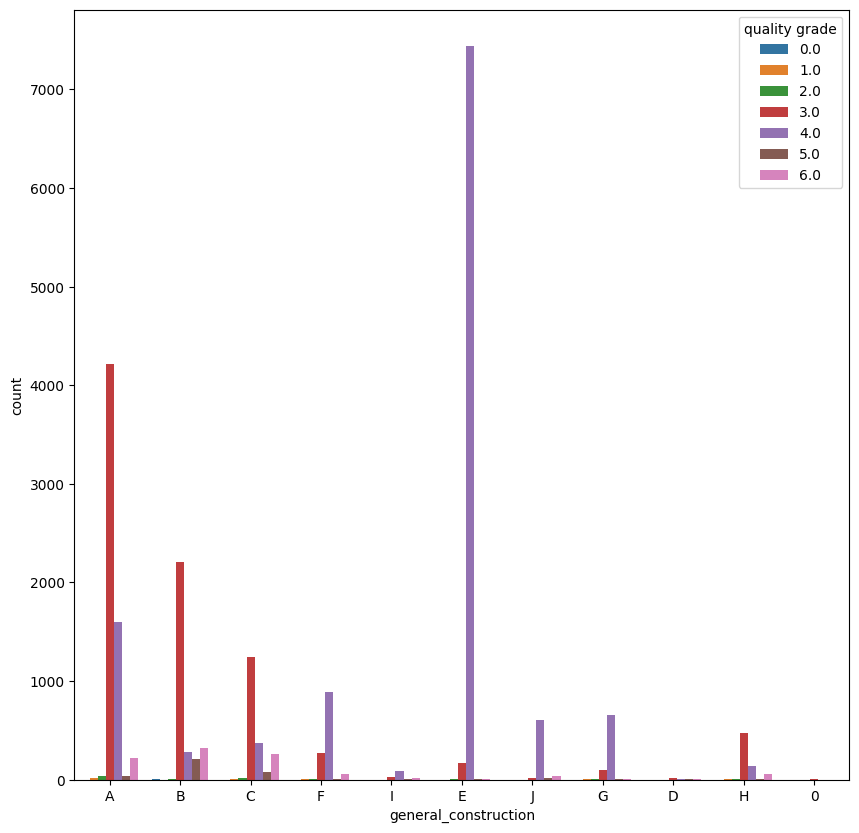

In [282]:
plt.figure(figsize=(10,10))
sns.countplot(x='general_construction',hue='quality_grade',data=df)
plt.legend(loc='upper right', title='quality grade')
plt.show()

In [283]:
df[['quality_grade','interior_condition','exterior_condition']].corr(method='spearman')

,quality_grade,interior_condition,exterior_condition
quality_grade,1.000000,0.287107,0.283899
interior_condition,0.287107,1.000000,0.977947
exterior_condition,0.283899,0.977947,1.000000


In [284]:
df.groupby('exterior_condition')[['interior_condition']].median()

,interior_condition
exterior_condition,
0.0,0.0
1.0,1.0
2.0,2.0
3.0,3.0
4.0,4.0
5.0,5.0
6.0,6.0
7.0,7.0


In [285]:
df['exterior_condition'].fillna(df['interior_condition'], inplace=True)
df['interior_condition'].fillna(df['exterior_condition'], inplace=True)



In [286]:
df[['exterior_condition','interior_condition']].isna().sum()

exterior_condition    25249
interior_condition    25249
dtype: int64

<b> Overall Condition </b>

In most cases, the interior and exterior conditions of the property are the same. But, sometimes, they don't. Since this columns are highly correlated with each other, dropping one of them will lose the information regarding the data with unmatched interior and exterior condition. So, we made a new column that can represents both condition.

In [287]:
df['overall_condition']=(df['interior_condition']+df['exterior_condition'])/2

In [288]:
df['overall_condition'].unique()

array([5. , 2. , 4. , 0. , 3. , 1. , nan, 3.5, 6. , 4.5, 7. , 2.5, 5.5,
       0.5, 1.5])

In [289]:
df['overall_condition'].nunique()

14

# Number of Rooms, Number of Bedrooms, Number of Bathrooms

In [290]:
df[['number_of_rooms','number_of_bedrooms','number_of_bathrooms']].describe()

,number_of_rooms,number_of_bedrooms,number_of_bathrooms
count,581310.000000,581310.000000,581310.000000
mean,3.776665,2.010932,0.763033
std,3.108430,1.661266,0.762545
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,6.000000,3.000000,1.000000
75%,6.000000,3.000000,1.000000
max,89.000000,93.000000,90.000000


In [291]:
df[['number_of_rooms','number_of_bedrooms','number_of_bathrooms']].isna().sum()

number_of_rooms        6
number_of_bedrooms     6
number_of_bathrooms    6
dtype: int64

In [292]:
i_nan_rooms=df[df['number_of_rooms'].isna()==True].index
print(df[df['number_of_bathrooms'].isna()].index)
print(df[df['number_of_bedrooms'].isna()].index)
print(df[df['number_of_rooms'].isna()].index)

Int64Index([2619, 11847, 32370, 529827, 536900, 540822], dtype='int64')
Int64Index([2619, 11847, 32370, 529827, 536900, 540822], dtype='int64')
Int64Index([2619, 11847, 32370, 529827, 536900, 540822], dtype='int64')


In [293]:
df.loc[i_nan_rooms][['number_of_bedrooms','number_of_rooms','number_of_bathrooms','zoning','building_code_description','category_code_description','location']]

,number_of_bedrooms,number_of_rooms,number_of_bathrooms,zoning,building_code_description,category_code_description,location
2619,NaN,NaN,NaN,RSA5,ROW W/GAR 4 STY MASONRY,Single Family,1434 S 04TH ST
11847,NaN,NaN,NaN,RSA5,VACANT LAND RESIDE < ACRE,Vacant Land,1008-10 S FAIRHILL ST
32370,NaN,NaN,NaN,RSA5,VACANT LAND RESIDE < ACRE,Vacant Land,303 GREEN ST
529827,NaN,NaN,NaN,SPAIR,CAR/TRUCK RENTAL MASONRY,Commercial,8101 BARTRAM AVE
536900,NaN,NaN,NaN,CMX2,VACANT LAND COMMER < ACRE,Vacant Land,1406-18 N FRONT ST
540822,NaN,NaN,NaN,CMX2,OFF BLD N/COM W/PKG MASON,Commercial,1919 COTTMAN AVE


<b> Vacant Land</b>

In [294]:
i_v_rooms=df[(df['number_of_rooms'].isna()==True)&(df['building_code_description'].str.contains('VACANT'))].index

In [295]:

df.loc[i_v_rooms,'number_of_rooms']=0
df.loc[i_v_rooms,'number_of_bedrooms']=0
df.loc[i_v_rooms,'number_of_bathrooms']=0
df.loc[[529827,540822],'number_of_bedrooms']=0

In [296]:
df[(df['number_of_rooms'].isna()==True)][['number_of_bedrooms','number_of_rooms','number_of_bathrooms','zoning','building_code_description','category_code_description','location']]

,number_of_bedrooms,number_of_rooms,number_of_bathrooms,zoning,building_code_description,category_code_description,location
2619,NaN,NaN,NaN,RSA5,ROW W/GAR 4 STY MASONRY,Single Family,1434 S 04TH ST
529827,0.0,NaN,NaN,SPAIR,CAR/TRUCK RENTAL MASONRY,Commercial,8101 BARTRAM AVE
540822,0.0,NaN,NaN,CMX2,OFF BLD N/COM W/PKG MASON,Commercial,1919 COTTMAN AVE


<b> 0 rooms </b>

In [297]:
len(df[df['number_of_rooms']==0])

223828

In [298]:
len(df[df['number_of_rooms']==0])/len(df)*100

38.50367098101549

In [299]:
df.reset_index(drop=True, inplace=True)

In [300]:
a=[]
for i in range(len(df)):
    if df['number_of_rooms'].loc[i]==0:
        x=df['number_of_bathrooms'].loc[i]+df['number_of_bedrooms'].loc[i]
        a.append(x)
    else:
        x=df['number_of_rooms'].loc[i]
        a.append(x)
len(a)

581316

In [301]:
df['number_of_rooms']=a
df['number_of_rooms']


0         7.0
1         4.0
2         5.0
3         8.0
4         6.0
         ... 
581311    0.0
581312    0.0
581313    0.0
581314    0.0
581315    0.0
Name: number_of_rooms, Length: 581316, dtype: float64

In [302]:
df[df['number_of_rooms']==0]['number_of_bedrooms'].sum()
df[df['number_of_rooms']==0]['number_of_bathrooms'].sum()

0.0

<b> Other than Vacant Land, Parking Lots </b>

In [303]:
pd.set_option('display.max_rows',10)
df[(df['number_of_rooms']==0)&(~df['building_code_description'].str.contains('VACANT'))
  &(~df['building_code_description'].str.contains('PKG LOT'))&(~df['building_code_description'].str.contains('CAR LOT'))
   &(~df['building_code_description'].str.contains('PARKING'))&(~df['building_code_description'].str.contains('CEMET'))].head()

,basements,building_code,building_code_description,category_code,category_code_description,central_air,depth,exterior_condition,fireplaces,frontage,...,unit,view_type,year_built,zip_code,zoning,new_zoning,sale_year,sale_year_group,parking_spaces,overall_condition
191,D,O50,ROW 3 STY MASONRY,1,Single Family,Y,45.41,2.0,0,13.5,...,NaN,I,1920,19147,RSA5,Residential Single Family,2016.0,2020-2016,0,2.0
192,D,O50,ROW 3 STY MASONRY,1,Single Family,N,82.00,4.0,0,13.0,...,NaN,I,1920,19147,RSA5,Residential Single Family,1977.0,1980-1976,0,4.0
193,D,O50,ROW 3 STY MASONRY,1,Single Family,N,82.79,4.0,0,13.0,...,NaN,I,1920,19147,RSA5,Residential Single Family,1978.0,1980-1976,0,4.0
229,0,P60,ROW W/GAR 3.5 STY MASONRY,1,Single Family,Y,54.00,3.0,0,20.0,...,000000C,I,2006,19147,I2,Industrial,2017.0,2020-2016,1,3.0
233,0,P60,ROW W/GAR 3.5 STY MASONRY,1,Single Family,Y,54.00,3.0,0,20.0,...,000000G,I,2006,19147,I2,Industrial,2015.0,2015-2011,1,3.0


In [304]:
pd.set_option('display.max_rows',10)
index_rooms0=df[(df['number_of_rooms']==0)&(~df['building_code_description'].str.contains('VACANT'))
                &(~df['building_code_description'].str.contains('PKG LOT'))&(~df['building_code_description'].str.contains('CAR LOT'))
                &(~df['building_code_description'].str.contains('PARKING'))&(~df['building_code_description'].str.contains('CEMET'))].index
index_rooms0

Int64Index([   191,    192,    193,    229,    233,    302,    355,    400,
               424,    429,
            ...
            581306, 581307, 581308, 581309, 581310, 581311, 581312, 581313,
            581314, 581315],
           dtype='int64', length=148156)

In [305]:
df.loc[index_rooms0,'number_of_rooms']=np.NaN

In [306]:
df['number_of_rooms']=df.groupby('building_code_description')['number_of_rooms'].apply(lambda x: x.fillna(x.median()))

C:\Users\ashut\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\lib\nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\ashut\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\lib\nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\ashut\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\lib\nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\ashut\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\lib\nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\ashut\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\lib\nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\ashut\

C:\Users\ashut\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\lib\nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\ashut\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\lib\nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\ashut\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\lib\nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\ashut\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\lib\nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\ashut\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\lib\nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\ashut\

C:\Users\ashut\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\lib\nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\ashut\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\lib\nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\ashut\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\lib\nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\ashut\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\lib\nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\ashut\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\lib\nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\ashut\

In [307]:
df['number_of_rooms'].isna().sum()

3801

In [308]:
pd.set_option('display.max_rows',10)
df[df['number_of_rooms'].isna()==True]

,basements,building_code,building_code_description,category_code,category_code_description,central_air,depth,exterior_condition,fireplaces,frontage,...,unit,view_type,year_built,zip_code,zoning,new_zoning,sale_year,sale_year_group,parking_spaces,overall_condition
400,0,Z10,MISC DWELL 1 STY MASONRY,1,Single Family,Y,69.25,4.0,0,14.00,...,NaN,I,1925,19147,RSA5,Residential Single Family,2018.0,2020-2016,1,4.0
30888,H,U80,ROW CONV/APT 4.5 STY MAS,2,Multi Family,N,125.00,3.0,0,20.54,...,NaN,I,1830,19106,RM1,Residential Multi Family,1964.0,1965-1961,0,3.0
31746,NaN,OA0,GAR W/COMM AREA MASONRY,4,Commercial,0,128.00,4.0,0,36.00,...,NaN,I,1920,19123,CMX25,Mixed Used,2017.0,2020-2016,0,4.0
31906,NaN,V31,PRIV GAR 2 STY MAS+OTH,1,Single Family,0,34.00,4.0,0,12.00,...,NaN,I,1920,19123,RSA5,Residential Single Family,1985.0,1985-1981,0,4.0
33239,NaN,NB0,PUB UTIL 2 STY MASONRY,4,Commercial,0,80.00,4.0,0,80.00,...,NaN,I,1915,19147,CMX4,Mixed Used,1930.0,1930-1926,1,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
573128,NaN,6D0,COM CONDO 4 STY MASONRY,4,Commercial,0,0.00,3.0,0,0.00,...,000000B,I,1990,19146,RM1,Residential Multi Family,2016.0,2020-2016,0,3.0
573302,NaN,7,INDUS CONDO,5,Industrial,Y,0.00,5.0,0,0.00,...,00000WD,I,1900,19134,ICMX,Mixed Used,2004.0,2005-2001,0,5.0
577030,NaN,2,AIR RIGHTS RESIDENTIAL,1,Single Family,N,0.00,0.0,0,0.00,...,0000UTL,I,1900,19125,IRMX,Mixed Used,2008.0,2010-2006,0,0.0
580789,NaN,ZE0,MISC ADMIN BLDG MASONRY,4,Commercial,0,0.00,4.0,0,0.00,...,NaN,I,1972,19114,RM2,Residential Multi Family,1972.0,1975-1971,0,4.0


In [309]:
pd.set_option('display.max_rows',10)
df[(df['number_of_bathrooms']==0)&(~df['building_code_description'].str.contains('VACANT'))
   &(~df['building_code_description'].str.contains('PKG LOT'))&(~df['building_code_description'].str.contains('CAR LOT'))
   &(~df['building_code_description'].str.contains('PARKING'))&(~df['building_code_description'].str.contains('CEMET'))
  ][['number_of_bedrooms','number_of_rooms','number_of_bathrooms','zoning','building_code_description','category_code_description','location']]

,number_of_bedrooms,number_of_rooms,number_of_bathrooms,zoning,building_code_description,category_code_description,location
63,3.0,6.0,0.0,ICMX,ROW W/GAR 3 STY MAS+OTHER,Single Family,134 REED ST
64,3.0,6.0,0.0,ICMX,ROW W/GAR 3 STY MAS+OTHER,Single Family,136 REED ST
65,3.0,6.0,0.0,ICMX,ROW W/GAR 3 STY MAS+OTHER,Single Family,138 REED ST
67,3.0,6.0,0.0,ICMX,ROW W/GAR 3 STY MAS+OTHER,Single Family,142 REED ST
191,0.0,6.0,0.0,RSA5,ROW 3 STY MASONRY,Single Family,130 GREENWICH ST
...,...,...,...,...,...,...,...
581311,0.0,3.0,0.0,RMX3,RES CONDO 5+ STY MASONRY,Single Family,237-47 S 18TH ST
581312,0.0,3.0,0.0,RMX3,RES CONDO 5+ STY MASONRY,Single Family,237-47 S 18TH ST
581313,0.0,3.0,0.0,RMX3,RES CONDO 5+ STY MASONRY,Single Family,237-47 S 18TH ST
581314,0.0,3.0,0.0,RMX3,RES CONDO 5+ STY MASONRY,Single Family,237-47 S 18TH ST


In [310]:
i_bath_0=df[(df['number_of_bathrooms']==0)&(~df['building_code_description'].str.contains('VACANT'))
   &(~df['building_code_description'].str.contains('PKG LOT'))&(~df['building_code_description'].str.contains('CAR LOT'))
   &(~df['building_code_description'].str.contains('PARKING'))&(~df['building_code_description'].str.contains('CEMET'))
  ].index
i_bath_0

Int64Index([    63,     64,     65,     67,    191,    192,    193,    196,
               229,    233,
            ...
            581306, 581307, 581308, 581309, 581310, 581311, 581312, 581313,
            581314, 581315],
           dtype='int64', length=158985)

In [311]:
df.loc[i_bath_0,'number_of_bathrooms']=np.NaN

In [312]:
df['number_of_bathrooms']=df.groupby('building_code_description')['number_of_bathrooms'].apply(lambda x: x.fillna(x.median()))

C:\Users\ashut\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\lib\nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\ashut\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\lib\nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\ashut\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\lib\nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\ashut\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\lib\nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\ashut\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\lib\nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\ashut\

C:\Users\ashut\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\lib\nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\ashut\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\lib\nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\ashut\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\lib\nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\ashut\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\lib\nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\ashut\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\lib\nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\ashut\

C:\Users\ashut\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\lib\nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\ashut\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\lib\nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\ashut\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\lib\nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\ashut\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\lib\nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\ashut\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\lib\nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\ashut\

In [313]:
df['number_of_bathrooms'].isna().sum()

5201

<b> Total rooms < Bedroom + Bathroom </b>

In [314]:
b=df['number_of_rooms']<(df['number_of_bedrooms']+df['number_of_bathrooms'])
b

0         False
1         False
2         False
3         False
4         False
          ...  
581311    False
581312    False
581313    False
581314    False
581315    False
Length: 581316, dtype: bool

In [315]:
df.loc[b[b==True].index]

,basements,building_code,building_code_description,category_code,category_code_description,central_air,depth,exterior_condition,fireplaces,frontage,...,unit,view_type,year_built,zip_code,zoning,new_zoning,sale_year,sale_year_group,parking_spaces,overall_condition
33,I,O50,ROW 3 STY MASONRY,1,Single Family,Y,36.0,3.0,0,34.00,...,NaN,I,2008,19147,RSA5,Residential Single Family,2018.0,2020-2016,0,3.0
34,A,O50,ROW 3 STY MASONRY,1,Single Family,Y,36.0,1.0,0,34.00,...,NaN,I,2009,19147,RSA5,Residential Single Family,2016.0,2020-2016,0,1.0
62,A,P51,ROW W/GAR 3 STY MAS+OTHER,1,Single Family,Y,84.0,1.0,0,16.67,...,NaN,I,2014,19148,ICMX,Mixed Used,2014.0,2015-2011,1,1.0
66,A,P51,ROW W/GAR 3 STY MAS+OTHER,1,Single Family,Y,84.0,1.0,0,16.67,...,NaN,I,2014,19148,ICMX,Mixed Used,2014.0,2015-2011,1,1.0
206,D,P50,ROW W/GAR 3 STY MASONRY,1,Single Family,N,82.0,4.0,0,32.00,...,NaN,I,1925,19147,RSA5,Residential Single Family,1973.0,1975-1971,1,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
578573,NaN,550,RES CONDO 3 STY MASONRY,1,Single Family,Y,0.0,4.0,0,0.00,...,0000001,I,1900,19130,RM1,Residential Multi Family,2002.0,2005-2001,0,4.0
578574,NaN,550,RES CONDO 3 STY MASONRY,1,Single Family,Y,0.0,4.0,0,0.00,...,0000002,I,1900,19130,RM1,Residential Multi Family,2002.0,2005-2001,0,4.0
578575,NaN,550,RES CONDO 3 STY MASONRY,1,Single Family,Y,0.0,4.0,0,0.00,...,0000003,I,1900,19130,RM1,Residential Multi Family,2002.0,2005-2001,0,4.0
580262,NaN,590,RES CONDO 5+ STY MASONRY,1,Single Family,Y,0.0,4.0,0,0.00,...,000003B,C,1910,19103,RMX3,Mixed Used,1999.0,2000-1996,1,4.0


In [316]:
c=[]
for i in range(len(df)):
    if df['number_of_rooms'].loc[i]<(df['number_of_bedrooms'].loc[i]+df['number_of_bathrooms'].loc[i]):
        x=df['number_of_bathrooms'].loc[i]+df['number_of_bedrooms'].loc[i]
        c.append(x)
    else:
        x=df['number_of_rooms'].loc[i]
        c.append(x)
len(c)

581316

In [317]:
df['number_of_rooms']=c
df['number_of_rooms']

0         7.0
1         4.0
2         5.0
3         8.0
4         6.0
         ... 
581311    3.0
581312    3.0
581313    3.0
581314    3.0
581315    3.0
Name: number_of_rooms, Length: 581316, dtype: float64

In [318]:
b=df['number_of_rooms']<(df['number_of_bedrooms']+df['number_of_bathrooms'])
b

0         False
1         False
2         False
3         False
4         False
          ...  
581311    False
581312    False
581313    False
581314    False
581315    False
Length: 581316, dtype: bool

In [319]:
b[b==True].index

Int64Index([], dtype='int64')

In [320]:
df[['number_of_rooms','number_of_bedrooms','number_of_bathrooms']].isna().sum()

number_of_rooms        3801
number_of_bedrooms        1
number_of_bathrooms    5201
dtype: int64

# Frontage, Depth, Total Area and Total Livable Area

In [321]:
df[['depth','frontage','total_area','total_livable_area']].describe()

,depth,frontage,total_area,total_livable_area
count,5.813150e+05,5.813150e+05,5.813150e+05,5.813100e+05
mean,1.110795e+02,1.098565e+03,5.045587e+03,2.258814e+03
std,4.271169e+03,5.842341e+05,2.965255e+05,1.681276e+04
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,5.700000e+01,1.500000e+01,8.824500e+02,1.025000e+03
50%,7.700000e+01,1.600000e+01,1.280000e+03,1.230000e+03
75%,1.000000e+02,2.041000e+01,2.050915e+03,1.588000e+03
max,1.829520e+06,4.320260e+08,2.076941e+08,2.500000e+06


In [322]:
df[['depth','frontage','total_area','total_livable_area']].isna().sum()

depth                 1
frontage              1
total_area            1
total_livable_area    6
dtype: int64

<AxesSubplot: >

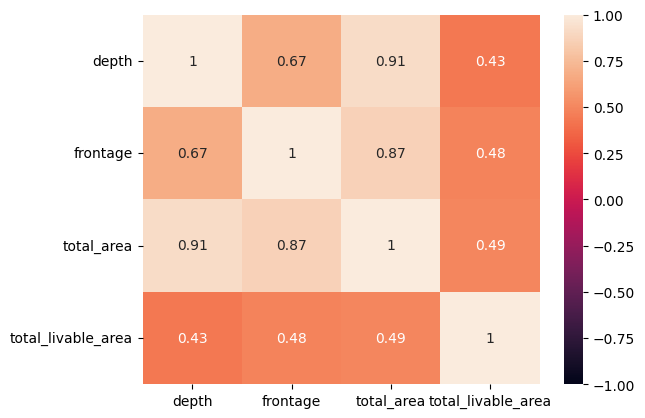

In [323]:
corr2 = df[['depth','frontage','total_area','total_livable_area']].corr(method='spearman')
sns.heatmap(corr2,vmin=-1, vmax=1, annot=True)

<b> Frontage </b>

In [324]:
df[df['frontage'].isna()==True].index

Int64Index([540700], dtype='int64')

In [325]:
df[df['frontage']==0]['frontage'].count()

35036

<b> Depth </b>

In [326]:
na_depth=df[df['depth'].isna()==True].index

In [327]:
df.loc[na_depth]

,basements,building_code,building_code_description,category_code,category_code_description,central_air,depth,exterior_condition,fireplaces,frontage,...,unit,view_type,year_built,zip_code,zoning,new_zoning,sale_year,sale_year_group,parking_spaces,overall_condition
540700,NaN,DE0,OFF BLD N/COM W/PKG MASON,4,Commercial,0,NaN,NaN,0,NaN,...,NaN,NaN,NaN,19111,CMX2,Mixed Used,2019.0,2020-2016,0,NaN


In [328]:
# Check whether there are any 0 value on depth
df[df['depth']==0]['depth'].count()

35075

<b> Total Area </b>

In [329]:
df[df['total_area'].isna()==True].index

Int64Index([540700], dtype='int64')

In [330]:
df[df['total_area']==0]['total_area'].count()

34901

<b> Crosschecking </b>

In [331]:
df[(df['depth']<100)&(df['depth']>0)][['depth','frontage','total_area']]

,depth,frontage,total_area
0,49.0,15.90,779.0
1,49.0,15.90,779.1
2,49.0,14.80,725.2
6,75.0,16.00,1200.0
7,90.0,29.17,2625.3
...,...,...,...
578724,62.0,16.80,1041.6
578725,62.0,16.80,1041.6
578726,45.0,18.00,810.0
578727,45.0,18.00,810.0


In [332]:
df2=df[(df['total_area']==0)][['depth','frontage','total_area']].reset_index(drop=True)

In [333]:
df2.head()

,depth,frontage,total_area
0,0.0,0.0,0.0
1,0.0,0.0,0.0
2,0.0,0.0,0.0
3,0.0,0.0,0.0
4,0.0,0.0,0.0


In [334]:
df2['depth']=df2['depth'].apply(lambda x: np.NaN if x==0 else x)
df2['frontage']=df2['frontage'].apply(lambda x: np.NaN if x==0 else x)
df2['total_area']=df2['total_area'].apply(lambda x: np.NaN if x==0 else x)

In [335]:
df2.isna().sum()

depth         34901
frontage      34898
total_area    34901
dtype: int64

In [336]:
df2[df2['frontage'].notna()]

,depth,frontage,total_area
279,NaN,29.34,NaN
466,NaN,350.00,NaN
467,NaN,500.00,NaN


In [337]:
total_area_0=df[(df['total_area']==0)].index

In [338]:
df.drop(index=total_area_0, inplace=True)

In [339]:
df = df.reset_index(drop=True)

In [340]:
a=[]
for i in range(len(df)):
    if df['frontage'].loc[i]*df['depth'].loc[i]!=df['total_area'].loc[i]:
        a.append(i)
len(a)

156763

In [341]:
df.loc[a][['depth','frontage','total_area','total_livable_area','number_stories','building_code_description','category_code_description']]

,depth,frontage,total_area,total_livable_area,number_stories,building_code_description,category_code_description
0,49.00,15.90,779.00,1650.0,0.0,ROW W/GAR 3 STY MASONRY,Single Family
10,90.00,18.08,1627.20,1266.0,2.0,ROW B/GAR 2 STY MASONRY,Single Family
24,48.00,15.41,739.68,1436.0,3.0,ROW 3 STY MASONRY,Single Family
31,45.46,20.00,909.00,2162.0,3.0,ROW W/GAR 3 STY MASONRY,Single Family
36,44.75,15.50,693.62,1024.0,2.0,ROW 2 STY MASONRY,Single Family
...,...,...,...,...,...,...,...
546404,77.75,17.67,1373.61,1624.0,3.0,RES CONDO 3 STY MAS+OTH,Single Family
546405,77.75,17.67,1373.61,792.0,3.0,RES CONDO 3 STY MAS+OTH,Single Family
546406,77.75,17.67,1373.61,1111.0,3.0,RES CONDO 3 STY MAS+OTH,Single Family
546408,62.00,16.80,1041.60,1854.0,3.0,RES CONDO 3 STY MAS+OTH,Single Family


In [342]:
drop2=df[(df['depth']>df['total_area'])|(df['frontage']>df['total_area'])].index

In [343]:
df.drop(index=drop2, inplace=True)

In [344]:
df.reset_index (drop=True, inplace=True)

In [345]:
df['total_area'].describe()

count    5.463520e+05
mean     5.366703e+03
std      3.058627e+05
min      1.000000e+00
25%      9.500400e+02
50%      1.349545e+03
75%      2.179000e+03
max      2.076941e+08
Name: total_area, dtype: float64

<AxesSubplot: >

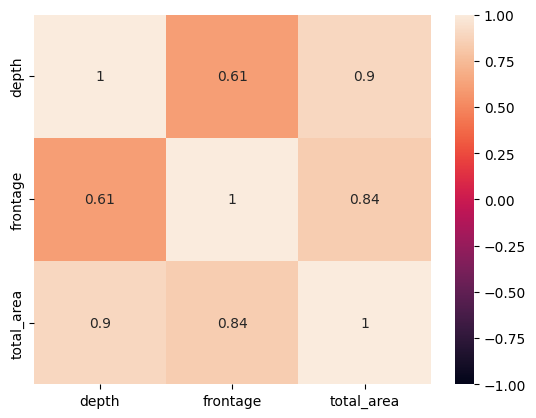

In [346]:
corr2=df[['depth','frontage','total_area']].corr('spearman')
sns.heatmap(corr2, vmin=-1, vmax=1, annot=True)

<b> Total Livable Area </b>

In [347]:
i_nan_liv=df[df['total_livable_area'].isna()==True].index

In [348]:
df.loc[i_nan_liv][['total_area','zoning','building_code_description','category_code_description']]

,total_area,zoning,building_code_description,category_code_description
2614,640.00,RSA5,ROW W/GAR 4 STY MASONRY,Single Family
11830,437.40,RSA5,VACANT LAND RESIDE < ACRE,Vacant Land
32320,3390.34,RSA5,VACANT LAND RESIDE < ACRE,Vacant Land
529198,1268182.35,SPAIR,CAR/TRUCK RENTAL MASONRY,Commercial
536214,8610.00,CMX2,VACANT LAND COMMER < ACRE,Vacant Land
539996,NaN,CMX2,OFF BLD N/COM W/PKG MASON,Commercial


In [349]:
i_nanto0=df[(df['total_livable_area'].isna()==True)&((df['category_code_description'].str.contains('Vacant'))|(df['category_code_description']))]

In [350]:
df[df['total_livable_area'].isna()==True].index

Int64Index([2614, 11830, 32320, 529198, 536214, 539996], dtype='int64')

In [351]:
pd.set_option('display.max_rows',603)
df[(df['total_livable_area']==0)&(~df['building_code_description'].str.contains('VACANT'))&(~df['building_code_description'].str.contains('WAREHOUSE'))&(~df['building_code_description'].str.contains('PKG LOT'))
  &(~df['building_code_description'].str.contains('CAR LOT'))&(~df['category_code_description'].str.contains('Commercial'))
  &(~df['category_code_description'].str.contains('Indus'))
  &(~df['building_code_description'].str.contains('PARKING'))]

,basements,building_code,building_code_description,category_code,category_code_description,central_air,depth,exterior_condition,fireplaces,frontage,...,unit,view_type,year_built,zip_code,zoning,new_zoning,sale_year,sale_year_group,parking_spaces,overall_condition
1975,0,V10,PRIV GAR 1 STY MASONRY,1,Single Family,0,49.77,5.0,0,15.91,...,NaN,I,1925,19148,RSA5,Residential Single Family,2005.0,2005-2001,0,5.0
3158,D,V10,PRIV GAR 1 STY MASONRY,1,Single Family,N,75.00,4.0,0,38.00,...,NaN,I,1920,19147,RSA5,Residential Single Family,1918.0,1920-1916,0,4.0
6797,D,V10,PRIV GAR 1 STY MASONRY,1,Single Family,N,56.45,4.0,0,16.00,...,NaN,I,1920,19148,RSA5,Residential Single Family,2008.0,2010-2006,1,4.0
7333,NaN,P50,ROW W/GAR 3 STY MASONRY,1,Single Family,Y,45.00,1.0,0,14.00,...,NaN,I,2018,19147,CMX3,Mixed Used,2011.0,2015-2011,1,1.0
7440,NaN,O30,ROW 2 STY MASONRY,1,Single Family,0,45.66,0.0,0,14.00,...,NaN,NaN,1920,19147,RSA5,Residential Single Family,1983.0,1985-1981,1,0.0
9517,NaN,P50,ROW W/GAR 3 STY MASONRY,1,Single Family,0,70.00,0.0,0,16.00,...,NaN,NaN,0000,19147,RSA5,Residential Single Family,2010.0,2010-2006,1,0.0
10387,A,O50,ROW 3 STY MASONRY,1,Single Family,Y,58.00,1.0,0,14.75,...,NaN,I,2018,19147,RSA5,Residential Single Family,2018.0,2020-2016,0,1.0
11297,NaN,O10,ROW 1 STY MASONRY,1,Single Family,Y,58.00,4.0,0,15.66,...,NaN,I,1920,19147,RSA5,Residential Single Family,2020.0,2020-2016,1,4.0
11788,NaN,O50,ROW 3 STY MASONRY,1,Single Family,0,37.00,6.0,0,14.66,...,NaN,I,1918,19147,RSA5,Residential Single Family,2015.0,2015-2011,0,6.0
11831,NaN,O50,ROW 3 STY MASONRY,1,Single Family,0,37.00,4.0,0,14.66,...,NaN,I,1918,19147,RSA5,Residential Single Family,2019.0,2020-2016,0,4.0


In [352]:
lv_otoNAN=df[(df['total_livable_area']==0)&(~df['building_code_description'].str.contains('VACANT'))&(~df['building_code_description'].str.contains('WAREHOUSE'))&(~df['building_code_description'].str.contains('PKG LOT'))
  &(~df['building_code_description'].str.contains('CAR LOT'))&(~df['category_code_description'].str.contains('Commercial'))
  &(~df['category_code_description'].str.contains('Indus'))
  &(~df['building_code_description'].str.contains('PARKING'))].index

In [353]:
df.loc[lv_otoNAN,'total_livable_area']=np.NaN

In [354]:
df[df['total_livable_area'].isna()==True].index

Int64Index([  1975,   2614,   3158,   6797,   7333,   7440,   9517,  10387,
             11297,  11788,
            ...
            544009, 544012, 544013, 544014, 544184, 544185, 544257, 544551,
            544894, 545162],
           dtype='int64', length=432)

In [355]:
df['total_livable_area']=df.groupby('building_code_description')['total_livable_area'].apply(lambda x: x.fillna(x.median()))

C:\Users\ashut\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\lib\nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\ashut\AppData\Local\Temp\ipykernel_15784\622010054.py:1: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df['total_livable_area']=df.groupby('building_code_description')['total_livable_area'].apply(lambda x: x.fillna(x.median()))


In [356]:
df['total_livable_area'].isna().sum()

26

# Number Stories

In [357]:
df['number_stories'].unique()

array([ 0.,  2.,  3.,  4.,  1., nan,  5.,  6.,  9.,  8., 11.,  7., 40.,
       20., 30., 22., 15., 14., 10., 12., 16., 13., 19., 17., 18., 28.,
       25., 24., 37., 34., 21., 26., 27., 23., 33., 39., 61., 32., 51.,
       45., 54., 41., 29., 58., 44., 43., 36.])

In [358]:
df['number_stories'].describe()

count    546347.000000
mean          1.643223
std           1.102851
min           0.000000
25%           1.000000
50%           2.000000
75%           2.000000
max          61.000000
Name: number_stories, dtype: float64

In [359]:
df['number_stories'].isna().sum()

6

<AxesSubplot: >

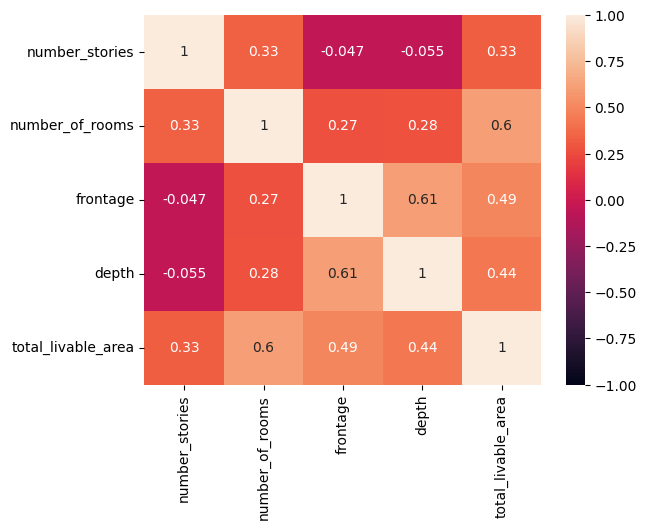

In [360]:
corr3=df[['number_stories','number_of_rooms','frontage','depth','total_livable_area']].corr('spearman')
sns.heatmap(corr3, vmin=-1, vmax=1, annot=True)

In [361]:
df[df['number_stories'].isna()==True].index

Int64Index([2614, 11830, 32320, 529198, 536214, 539996], dtype='int64')

In [362]:
df[df['number_stories'].isna()==True][['number_stories','number_of_rooms','building_code_description','category_code_description','zoning']]

,number_stories,number_of_rooms,building_code_description,category_code_description,zoning
2614,NaN,7.0,ROW W/GAR 4 STY MASONRY,Single Family,RSA5
11830,NaN,0.0,VACANT LAND RESIDE < ACRE,Vacant Land,RSA5
32320,NaN,0.0,VACANT LAND RESIDE < ACRE,Vacant Land,RSA5
529198,NaN,NaN,CAR/TRUCK RENTAL MASONRY,Commercial,SPAIR
536214,NaN,0.0,VACANT LAND COMMER < ACRE,Vacant Land,CMX2
539996,NaN,4.0,OFF BLD N/COM W/PKG MASON,Commercial,CMX2


In [363]:
df.loc[df[(df['number_stories'].isna()==True) & (df['category_code_description']=='Vacant Land')].index,'number_stories']=0

In [364]:
df[df['number_stories'].isna()==True][['number_stories','number_of_rooms','building_code_description','category_code_description','zoning']]

,number_stories,number_of_rooms,building_code_description,category_code_description,zoning
2614,NaN,7.0,ROW W/GAR 4 STY MASONRY,Single Family,RSA5
529198,NaN,NaN,CAR/TRUCK RENTAL MASONRY,Commercial,SPAIR
539996,NaN,4.0,OFF BLD N/COM W/PKG MASON,Commercial,CMX2


In [365]:
df[(df['number_stories']==0)
   &(~df['building_code_description'].str.contains('VACANT'))
   &(~df['building_code_description'].str.contains('CEMET'))
   &(~df['building_code_description'].str.contains('AMUSE'))
   &(~df['building_code_description'].str.contains('PKG LOT'))
   &(~df['building_code_description'].str.contains('CAR LOT'))
   &(~df['building_code_description'].str.contains('PARKING'))]

,basements,building_code,building_code_description,category_code,category_code_description,central_air,depth,exterior_condition,fireplaces,frontage,...,unit,view_type,year_built,zip_code,zoning,new_zoning,sale_year,sale_year_group,parking_spaces,overall_condition
0,D,P50,ROW W/GAR 3 STY MASONRY,1,Single Family,N,49.0,5.0,0,15.9,...,NaN,I,1920,19147,RSA5,Residential Single Family,1951.0,1955-1951,1,5.0
1,D,O50,ROW 3 STY MASONRY,1,Single Family,Y,49.0,2.0,0,15.9,...,NaN,I,1920,19147,RSA5,Residential Single Family,2017.0,2020-2016,0,2.0
140,0,R70,ROW B/GAR 4 STY MASONRY,1,Single Family,Y,64.0,4.0,0,15.0,...,NaN,I,2008,19147,RSA5,Residential Single Family,2016.0,2020-2016,1,4.0
141,0,R70,ROW B/GAR 4 STY MASONRY,1,Single Family,Y,64.0,4.0,0,15.0,...,NaN,I,2007,19147,RSA5,Residential Single Family,2014.0,2015-2011,1,4.0
142,0,R70,ROW B/GAR 4 STY MASONRY,1,Single Family,Y,64.0,4.0,0,16.0,...,NaN,I,2006,19147,RSA5,Residential Single Family,2007.0,2010-2006,1,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
546227,NaN,551,RES CONDO 3 STY MAS+OTH,1,Single Family,Y,0.0,3.0,1,0.0,...,NaN,I,1900,19104,RSA5,Residential Single Family,2013.0,2015-2011,1,3.0
546275,NaN,550,RES CONDO 3 STY MASONRY,1,Single Family,Y,100.0,1.0,0,120.0,...,0000004,I,2016,19125,RSA5,Residential Single Family,2016.0,2020-2016,0,1.0
546276,NaN,550,RES CONDO 3 STY MASONRY,1,Single Family,Y,1.0,1.0,0,1143.0,...,0000001,I,2012,19123,RSA5,Residential Single Family,2019.0,2020-2016,1,1.0
546314,E,550,RES CONDO 3 STY MASONRY,1,Single Family,Y,1.0,3.0,0,1193.0,...,0000001,I,1920,19130,RM1,Residential Multi Family,2017.0,2020-2016,1,3.0


In [366]:
i_str_0=df[(df['number_stories']==0)
   &(~df['building_code_description'].str.contains('VACANT'))
   &(~df['building_code_description'].str.contains('CEMET'))
   &(~df['building_code_description'].str.contains('AMUSE'))
   &(~df['building_code_description'].str.contains('PKG LOT'))
   &(~df['building_code_description'].str.contains('CAR LOT'))
   &(~df['building_code_description'].str.contains('PARKING'))].index
i_str_0

Int64Index([     0,      1,    140,    141,    142,    172,    202,    205,
               206,    225,
            ...
            545709, 545710, 545711, 545712, 545938, 546227, 546275, 546276,
            546314, 546319],
           dtype='int64', length=85745)

In [367]:
df.loc[i_str_0,'number_stories']=np.NaN

In [368]:
df['number_stories']=df.groupby('building_code_description')['number_stories'].apply(lambda x: x.fillna(x.median()))

C:\Users\ashut\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\lib\nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\ashut\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\lib\nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\ashut\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\lib\nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\ashut\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\lib\nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\ashut\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\lib\nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\ashut\

In [369]:
df['number_stories'].isna().sum()

96

# Topography and View Type

<b> Topography </b>

In [370]:
df['topography'].value_counts()

F    500814
A     30310
E      4817
B       251
C       173
D       113
0        24
Name: topography, dtype: int64

In [371]:
df['topography'].isna().sum()

9851

In [372]:
# Percentage of Missing values
df['topography'].isna().sum()/len(df)*100

1.8030467481646482

<b> View Type </b>

In [373]:
df['view_type'].value_counts()

I    497440
A     10672
C      5132
D      4010
0      3950
H      2710
E      2079
B       175
Name: view_type, dtype: int64

In [374]:
df['view_type'].isna().sum()

20185

In [375]:
# Percentage of Missing values
df['view_type'].isna().sum()/len(df)*100


3.6944978795760255

<b> Number Stories and View Type </b>

In [376]:
df[df['number_stories']==0]['view_type'].value_counts()

I    26102
0      715
D      148
A      145
E       50
C       28
H        9
B        5
Name: view_type, dtype: int64

In [377]:
df[(df['number_stories']==0)&(df['view_type']=='A')][['location','building_code_description','number_stories','category_code']]

,location,building_code_description,number_stories,category_code
20321,6218 CARPENTER ST,VACANT LAND RESIDE < ACRE,0.0,6
21028,5405R VINE ST,VACANT LAND RESIDE < ACRE,0.0,6
23267,1615 N CONESTOGA ST,VACANT LAND RESIDE < ACRE,0.0,6
37875,4127 MANTUA AVE,VACANT LAND RESIDE < ACRE,0.0,6
39994,1218 N 41ST ST,VACANT LAND RESIDE < ACRE,0.0,6
40338,446 E INDIANA AVE,VACANT LAND RESIDE < ACRE,0.0,6
40400,233 E INDIANA AVE,VACANT LAND RESIDE < ACRE,0.0,6
40616,515 E INDIANA AVE,VACANT LAND RESIDE < ACRE,0.0,6
40617,533 E INDIANA AVE,VACANT LAND RESIDE < ACRE,0.0,6
40620,543 E INDIANA AVE,VACANT LAND RESIDE < ACRE,0.0,6


In [378]:
df[df['number_stories']>0]['view_type'].value_counts()

I    471246
A     10527
C      5102
D      3862
0      3234
H      2701
E      2029
B       169
Name: view_type, dtype: int64

<b> View Type and Topography </b>

In [379]:
df.groupby('topography')['view_type'].value_counts()

topography  view_type
0           0                12
A           I             28056
            C               826
            A               686
            H               237
            D               133
            E                70
            0                17
            B                 1
B           C               148
            I                89
            A                 2
            E                 2
            D                 1
            H                 1
C           I                51
            B                43
            E                32
            A                29
            C                 9
            D                 1
            H                 1
D           I                97
            A                12
            C                 1
            D                 1
E           I              4144
            H               287
            A               203
            D                33
            E     

In [380]:
df['topography'].mode()

0    F
Name: topography, dtype: object

In [381]:
df['topography'].fillna('F',inplace=True)

In [382]:
df['topography'].isna().sum()

0

<b> View Type and Zoning </b>

The most logically sound to fill the view type is to match it with its zoning. Since our view is determined by surrounding environments.

In [383]:
df.groupby('new_zoning')['view_type'].value_counts()

new_zoning                          view_type
0                                   I               183
                                    D                13
                                    0                 3
                                    A                 1
                                    C                 1
Commercial                          I              1064
                                    D                54
                                    0                33
                                    A                 6
                                    C                 3
                                    E                 3
                                    B                 1
Industrial                          I              3646
                                    0               149
                                    E               120
                                    D                30
                                    A                22
  

In [384]:
df['view_type'].fillna('I',inplace=True)

In [385]:
df['view_type'].isna().sum()

0

# Property Administration Information


<b> Recording Date </b>

In [386]:
df['recording_date'].dtypes

dtype('O')

In [387]:
df = df.astype({'recording_date':'datetime64[ns]'})

In [388]:
df['recording_date'].isna().sum()

12

In [389]:
df[['recording_date','sale_date']]

,recording_date,sale_date
0,1951-01-31,1951-01-31
1,2017-05-09,2017-04-14
2,1975-09-04,1975-09-04
3,2012-02-16,2012-02-16
4,2017-07-31,2017-07-21
...,...,...
546348,2015-09-09,2015-09-04
546349,2018-12-19,2018-12-14
546350,2020-02-21,2019-12-30
546351,1998-05-07,1998-04-03


In [390]:
len(df[df['recording_date']!=df['sale_date']])

472722

In [391]:
df[df['recording_date']!=df['sale_date']][['recording_date','sale_date']]

,recording_date,sale_date
1,2017-05-09,2017-04-14
4,2017-07-31,2017-07-21
5,2006-03-02,2006-02-27
7,1999-03-24,1999-03-22
8,2019-08-06,2019-07-17
...,...,...
546348,2015-09-09,2015-09-04
546349,2018-12-19,2018-12-14
546350,2020-02-21,2019-12-30
546351,1998-05-07,1998-04-03


<b> Year Built </b>

In [392]:
df['year_built'].dtypes

dtype('O')

In [393]:
df['year_built'].unique()

array(['1920', '0000', '1960', '1987', '2016', '2018', '2008', '2009',
       '2014', '2019', '1924', '1900', '1915', '1854', '2011', '1955',
       '1954', '1939', '1929', '2007', '2006', '2010', '1925', '1945',
       '1902', '1944', '1981', '2005', '2004', '1904', '1930', '1965',
       '1906', '2003', '1991', '1997', '1990', '1994', '2017', '2015',
       '1918', '2013', '2012', '1948', '1980', '1907', '1931', '1916',
       '1940', '1972', '1905', '1926', '2002', '1988', '1949', '1951',
       '1950', '1941', '1910', '1921', '1914', '1874', '1936', '1923',
       '1932', '1935', '1933', '1956', '1927', '1934', '1919', '1996',
       '1908', '1894', '1866', nan, '1879', '1814', '1917', '1977',
       '1985', '1943', '1903', '1969', '1946', '1942', '1896', '1984',
       '1970', '1890', '1789', '1855', '1897', '2000', '1952', '2001',
       '1880', '1870', '1989', '1959', '1860', '1840', '1975', '1999',
       '1856', '1792', '1912', '1928', '1832', '1865', '1983', '1835',
       '1

In [394]:
df = df.astype({'year_built':float})

ValueError: could not convert string to float: '196Y'

In [396]:
df[df['year_built']=='196Y']

,basements,building_code,building_code_description,category_code,category_code_description,central_air,depth,exterior_condition,fireplaces,frontage,...,unit,view_type,year_built,zip_code,zoning,new_zoning,sale_year,sale_year_group,parking_spaces,overall_condition
35985,A,U70,ROW CONV/APT 4 STY MASON,2,Multi Family,Y,26.39,4.0,0,22.21,...,NaN,I,196Y,19123,RSA5,Residential Single Family,2019.0,2020-2016,1,4.0


In [397]:
# Change '196Y' become 1960 since Y is typo
df['year_built'] = df['year_built'].replace('196Y','1960')

In [398]:
df = df.astype({'year_built':float})

In [399]:
df['year_built'].describe()

count    546347.000000
mean       1772.411619
std         538.052928
min           0.000000
25%        1920.000000
50%        1925.000000
75%        1950.000000
max        2020.000000
Name: year_built, dtype: float64

In [400]:
len(df[df['year_built']==0])

46012

In [401]:
len(df[df['year_built']>2020])

0

In [402]:
i_YB_1950=df[df['year_built']>2020].index
df.loc[i_YB_1950,'year_built']=1950

In [403]:
pd.set_option('display.max_rows',10)
df1=df[(df['year_built']==0)&(~df['building_code_description'].str.contains('VACANT'))&(~df['building_code_description'].str.contains('VACANT'))]

In [404]:
rules=dict(df1.groupby('location')['year_built'].agg(pd.Series.mean))
rules

{'1 APPLETREE CT': 0.0,
 '1 MUSTIN ST': 0.0,
 '1 N 30TH ST': 0.0,
 '1 S CHRIS COLUMBUS BLVD': 0.0,
 '1 WASHINGTON AVE': 0.0,
 '10 APPLETREE CT': 0.0,
 '100 CARPENTER LN': 0.0,
 '100 E GODFREY AVE': 0.0,
 '100 EMILY ST': 0.0,
 '100 N 19TH ST': 0.0,
 '100 SPRING LN': 0.0,
 '100 SUMAC ST': 0.0,
 '1000 OAK LN': 0.0,
 '1000 W GLENWOOD AVE': 0.0,
 '1000 W TABOR RD': 0.0,
 '1000R E WYOMING AVE': 0.0,
 '1001 70TH AVE': 0.0,
 '1001 LONGSHORE AVE': 0.0,
 '1001 ST VINCENT ST': 0.0,
 '1001 UNRUH AVE': 0.0,
 '1001 W WINGOHOCKING ST': 0.0,
 '1001-19 E CHELTEN AVE': 0.0,
 '1001-19 N 5TH ST': 0.0,
 '1001-19 RIDGE AVE': 0.0,
 '10018 SANDMEYER LN': 0.0,
 '1002 S FAIRHILL ST': 0.0,
 '1002 WOOD ST': 0.0,
 '1004 UNRUH AVE': 0.0,
 '1004-06 WOOD ST': 0.0,
 '1005 FRANKLIN MILLS CIR': 0.0,
 '1005 NEW MARKET ST': 0.0,
 '1006 BUTTONWOOD ST': 0.0,
 '1006 N 40TH ST': 0.0,
 '1006-10 W YORK ST': 0.0,
 '1008-16 GERMANTOWN AVE': 0.0,
 '1008-16 WOOD ST': 0.0,
 '1009 SPRING ST': 0.0,
 '1009-23 S 3RD ST': 0.0,
 '101 E ER

In [406]:
df1=df1[df1['location'].isin(dupe['dupe'])].sort_values(by='location')
df1[df1['year_built']!=0][['location','year_built']]

,location,year_built


In [407]:
index=df[df['year_built']==0].index
df.loc[index,'year_built']=np.nan

# Dropping Columns and Rows based EDA

<b> Columns </b>

In [408]:
pd.set_option('display.max_rows',48)
df.isna().sum()

basements                    224226
building_code                     0
building_code_description         0
category_code                     0
category_code_description         0
central_air                       0
depth                             1
exterior_condition            24994
fireplaces                        0
frontage                          1
fuel                         537501
garage_spaces                     0
garage_type                       0
general_construction          51166
interior_condition            24994
location                          0
mailing_street               340744
market_value                      0
number_of_bathrooms            5013
number_of_bedrooms                1
number_of_rooms                3628
number_stories                   96
other_building                    0
owner_1                           0
owner_2                      354301
parcel_number                     0
parcel_shape                      0
quality_grade               

In [411]:
df_predict=df.drop(columns=['basements','building_code','category_code','fuel','general_construction','mailing_street','owner_1','owner_2',
                            'quality_grade','recording_date','registry_number','type_heater','unit','garage_type'])

<b> Rows </b>

In [410]:
df_predict.isna().sum()

building_code_description        0
category_code_description        0
central_air                      0
depth                            1
exterior_condition           24994
fireplaces                       0
frontage                         1
garage_spaces                    0
interior_condition           24994
location                         0
market_value                     0
number_of_bathrooms           5013
number_of_bedrooms               1
number_of_rooms               3628
number_stories                  96
other_building                   0
parcel_number                    0
parcel_shape                     0
sale_date                       30
sale_price                       0
street_designation               0
topography                       0
total_area                       1
total_livable_area              26
unfinished                       0
view_type                        0
year_built                   46018
zip_code                         0
zoning              

In [412]:
df_predict=df_predict.drop(df_predict[df_predict['number_of_bathrooms'].isna()].index).reset_index(drop=True)

In [413]:
df_predict.isna().sum()

building_code_description        0
category_code_description        0
central_air                      0
depth                            1
exterior_condition           24993
fireplaces                       0
frontage                         1
garage_spaces                    0
interior_condition           24993
location                         0
market_value                     0
number_of_bathrooms              0
number_of_bedrooms               1
number_of_rooms                  0
number_stories                  64
other_building                   0
parcel_number                    0
parcel_shape                     0
sale_date                       30
sale_price                       0
street_designation               0
topography                       0
total_area                       1
total_livable_area               0
unfinished                       0
view_type                        0
year_built                   45581
zip_code                         0
zoning              

In [414]:
df_predict=df_predict.drop(df_predict[df_predict['number_of_bedrooms'].isna()].index).reset_index(drop=True)

In [415]:
df_predict.isna().sum()

building_code_description        0
category_code_description        0
central_air                      0
depth                            1
exterior_condition           24992
fireplaces                       0
frontage                         1
garage_spaces                    0
interior_condition           24992
location                         0
market_value                     0
number_of_bathrooms              0
number_of_bedrooms               0
number_of_rooms                  0
number_stories                  64
other_building                   0
parcel_number                    0
parcel_shape                     0
sale_date                       30
sale_price                       0
street_designation               0
topography                       0
total_area                       1
total_livable_area               0
unfinished                       0
view_type                        0
year_built                   45580
zip_code                         0
zoning              

In [416]:
df_predict=df_predict.drop(df_predict[df_predict['number_stories'].isna()].index).reset_index(drop=True)

In [417]:
df_predict.isna().sum()

building_code_description        0
category_code_description        0
central_air                      0
depth                            1
exterior_condition           24992
fireplaces                       0
frontage                         1
garage_spaces                    0
interior_condition           24992
location                         0
market_value                     0
number_of_bathrooms              0
number_of_bedrooms               0
number_of_rooms                  0
number_stories                   0
other_building                   0
parcel_number                    0
parcel_shape                     0
sale_date                       30
sale_price                       0
street_designation               0
topography                       0
total_area                       1
total_livable_area               0
unfinished                       0
view_type                        0
year_built                   45578
zip_code                         0
zoning              

In [418]:
df_predict=df_predict.drop(df_predict[df_predict['sale_date'].isna()].index).reset_index(drop=True)

In [419]:
df_predict.isna().sum()

building_code_description        0
category_code_description        0
central_air                      0
depth                            1
exterior_condition           24990
fireplaces                       0
frontage                         1
garage_spaces                    0
interior_condition           24990
location                         0
market_value                     0
number_of_bathrooms              0
number_of_bedrooms               0
number_of_rooms                  0
number_stories                   0
other_building                   0
parcel_number                    0
parcel_shape                     0
sale_date                        0
sale_price                       0
street_designation               0
topography                       0
total_area                       1
total_livable_area               0
unfinished                       0
view_type                        0
year_built                   45575
zip_code                         0
zoning              

In [420]:
df_predict=df_predict.drop(df_predict[df_predict['year_built'].isna()].index).reset_index(drop=True)

In [421]:
df_predict.isna().sum()

building_code_description    0
category_code_description    0
central_air                  0
depth                        0
exterior_condition           0
fireplaces                   0
frontage                     0
garage_spaces                0
interior_condition           0
location                     0
market_value                 0
number_of_bathrooms          0
number_of_bedrooms           0
number_of_rooms              0
number_stories               0
other_building               0
parcel_number                0
parcel_shape                 0
sale_date                    0
sale_price                   0
street_designation           0
topography                   0
total_area                   0
total_livable_area           0
unfinished                   0
view_type                    0
year_built                   0
zip_code                     0
zoning                       0
new_zoning                   0
sale_year                    0
sale_year_group              0
parking_

In [422]:
len(df_predict)

495670

# Cleaning and Initial EDA of Label

In [423]:
df_predict['market_value'].describe()

count    4.956700e+05
mean     2.428169e+05
std      2.114789e+06
min      0.000000e+00
25%      7.620000e+04
50%      1.320000e+05
75%      2.124000e+05
max      3.705564e+08
Name: market_value, dtype: float64

In [424]:
df_predict[df_predict['market_value']<20000]['category_code_description'].value_counts()

Single Family    5371
Multi Family       75
Industrial         48
Commercial         30
Vacant Land        26
Mixed Use           5
Name: category_code_description, dtype: int64

In [425]:
df_predict[df_predict['market_value']>=20000]['category_code_description'].value_counts()

Single Family    422036
Multi Family      41988
Mixed Use         14258
Commercial         9140
Industrial         2677
Vacant Land          16
Name: category_code_description, dtype: int64

In [426]:
len(df_predict[df_predict['market_value']<5000])

44

Since there are a lot of data and we can't check them one by one. Let's filter them using Q1 (25%) of Vacant Land's market value.

In [427]:
df_predict[df_predict['category_code_description']=='Vacant Land']['market_value'].describe()

count    4.200000e+01
mean     1.257143e+05
std      4.110346e+05
min      2.300000e+03
25%      6.725000e+03
50%      1.305000e+04
75%      4.477500e+04
max      2.500000e+06
Name: market_value, dtype: float64

In [428]:
df_predict[df_predict['category_code_description']=='Vacant Land']['market_value'].describe()['25%']

6725.0

In [429]:
df_predict = df_predict[df_predict['market_value']>6725]
len(df_predict)

495507

In [430]:
df_predict['market_value'].describe()

count    4.955070e+05
mean     2.428950e+05
std      2.115132e+06
min      6.800000e+03
25%      7.630000e+04
50%      1.320000e+05
75%      2.124000e+05
max      3.705564e+08
Name: market_value, dtype: float64

# Saving the Clean Data

In [431]:
df_predict['property_age']=2020-df_predict['year_built']

In [432]:
df_predict.drop(columns=['garage_spaces'],inplace=True)

In [433]:
df_predict.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 495507 entries, 0 to 495669
Data columns (total 34 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   building_code_description  495507 non-null  object        
 1   category_code_description  495507 non-null  object        
 2   central_air                495507 non-null  object        
 3   depth                      495507 non-null  float64       
 4   exterior_condition         495507 non-null  float64       
 5   fireplaces                 495507 non-null  object        
 6   frontage                   495507 non-null  float64       
 7   interior_condition         495507 non-null  float64       
 8   location                   495507 non-null  object        
 9   market_value               495507 non-null  float64       
 10  number_of_bathrooms        495507 non-null  float64       
 11  number_of_bedrooms         495507 non-null  float64 

In [434]:
df_predict.describe()

,depth,exterior_condition,frontage,interior_condition,market_value,number_of_bathrooms,number_of_bedrooms,number_of_rooms,number_stories,parcel_number,sale_price,total_area,total_livable_area,year_built,sale_year,overall_condition,property_age
count,495507.000000,495507.000000,495507.000000,495507.000000,4.955070e+05,495507.000000,495507.000000,495507.000000,495507.000000,4.955070e+05,4.955070e+05,4.955070e+05,4.955070e+05,495507.000000,495507.000000,495507.000000,495507.000000
mean,95.865029,3.897228,50.104749,3.894460,2.428950e+05,1.408701,2.311600,6.289224,2.141810,3.985475e+08,1.216647e+05,3.389638e+03,2.084046e+03,1935.267998,2003.658088,3.895844,84.732002
std,1684.618512,0.712939,2755.190869,0.716409,2.115132e+06,2.377778,1.588306,2.593276,0.628759,2.214983e+08,8.533552e+05,2.963183e+05,1.243429e+04,25.586249,14.658765,0.712036,25.586249
min,0.000000,0.000000,0.000000,0.000000,6.800000e+03,0.000000,0.000000,0.000000,0.000000,1.100060e+07,0.000000e+00,1.000000e+00,0.000000e+00,1652.000000,1918.000000,0.000000,0.000000
25%,61.750000,4.000000,15.000000,4.000000,7.630000e+04,1.000000,0.000000,6.000000,2.000000,2.220860e+08,1.000000e+00,9.602300e+02,1.096000e+03,1920.000000,1998.000000,4.000000,70.000000
50%,80.000000,4.000000,16.000000,4.000000,1.320000e+05,1.000000,3.000000,6.000000,2.000000,3.952215e+08,4.300000e+04,1.360000e+03,1.280000e+03,1925.000000,2007.000000,4.000000,95.000000
75%,100.000000,4.000000,21.500000,4.000000,2.124000e+05,1.000000,3.000000,6.000000,2.000000,5.611906e+08,1.299000e+05,2.160000e+03,1.638000e+03,1950.000000,2015.000000,4.000000,100.000000
max,544500.000000,7.000000,871200.000000,7.000000,3.705564e+08,90.000000,93.000000,154.000000,61.000000,8.886800e+08,1.600000e+08,2.076941e+08,2.445358e+06,2020.000000,2020.000000,7.000000,368.000000


In [435]:
df_predict.to_csv('./Data/df_predict.csv',index=False)